In [50]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('reshape2')
library('IRdisplay')
source('../../../src/tools.R')     # custom tools function
#source('../../../src/hdp_tools.R') # hdp related functions
source('../../../src/hdp_tools_yanis.R')
library(scales)
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [51]:
### Tools to get max and second max proba with corresponding components

add_first_second_predicted_component <- function(hdp_output, data) {
    # Return a dataframe giving for each patient the probability by component, as well as the assigned component and its probability (max_proba)
    # → Arguments
    #     - hdp_output: hdpSampleChain or hdpSampleMulti object
    #     - data      : original data

    # keep all DP but first (first level)
    dd_predicted <- data.frame(comp_dp_distn(hdp_output)$mean[-1,])

# change categories colnames
    colnames(dd_predicted) <- paste0('component_', 0:(ncol(dd_predicted)-1))
    components_colnames <- colnames(dd_predicted)

    # pprint various info
    print_and_flush(sprintf('Number of components: %d\n', ncol(dd_predicted) - 1))
    print_and_flush(sprintf('Number of NA rows   : %d\n', nrow(dd_predicted[rowSums(is.na(dd_predicted)) != 0,])))

    # evaluate for each row the predicted component
    dd_predicted['initial_predicted_component'] <- apply(dd_predicted, 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     return(which.max(x)-1)
                                                                })
    dd_predicted[, 'initial_predicted_component'] <- factor(dd_predicted[, 'initial_predicted_component'])


    dd_predicted['second_predicted_component'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     tmp <- names(which.max(x[x!=max(x)]))
                                                                     return(as.numeric(substr(tmp,nchar(tmp),nchar(tmp))))
                                                                })
    dd_predicted[, 'second_predicted_component'] <- factor(dd_predicted[, 'second_predicted_component'])
    
    # evaluate for each row the maximum probability associated to the predicted component
    
    dd_predicted['max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x))
                                                                            })

    dd_predicted['second_max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x[x!=max(x)]))
                                                                            })

    return (dd_predicted)
}

In [52]:
df_final <- read.table("../../../data/updated_dataset/modif_final.csv",sep = ',' , header = T)
rownames(df_final)<- df_final$data_pd
df_final <- df_final[,-1:-3]
df_master <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T)
rownames(df_master) <- df_master$data_pd
df_final <- merge(df_final,df_master[c('inv_3','inv_16')],by=0)
rownames(df_final) <- df_final$Row.names
df_final <- df_final[,-1]
dim(df_final)

[1] 2150  153

In [53]:
### Tools to launch HDP and get results

launch <- function(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab){
    number_of_chains <- chains
    chain_list <- vector('list', number_of_chains)
    hdp <- initialise_hdp_yanis(data = data,hh=base_dist,alphaa = aa,alphab= ab)


    for (i in 1:number_of_chains) {
        seed <- i * 100
        print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))

        # run single hdp chain
        chain_list[[i]] <- activate_and_run_hdp(hdp,
                                                initcc = initial_clusters,
                                                burnin = burn,
                                                n      = posterior_samples,
                                                space  = 20,
                                                seed   = seed)
        print_and_flush('\n')
    }

    multi_output <- hdp_multi_chain(chain_list)
    print(multi_output)
}

In [54]:
### Tools for distributions of HDP


num_cols = ncol(df_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1))/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_final,bin))
gaussian <- unlist(sapply(df_final,normal))
pois <- as.numeric(unlist(sapply(df_final,poisson)))
unif <- unlist(sapply(df_final,equally))
repetition <- unlist(sapply(df_final,repet))
lists<- list(binomial,gaussian,unif,repetition)


In [60]:
data <- df_final
posterior_samples <- 250
initial_clusters <- 20
burn <- 7000
chains <- 3
base_dist <- gaussian
aa <- 1
ab <-3

# I) Initial Component : Component 0 to 10

In [61]:
multi_output <- launch(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_cluster_10 <- extract_components(multi_output)

Initialise HDP on a 2150 x 153 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 750 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of 

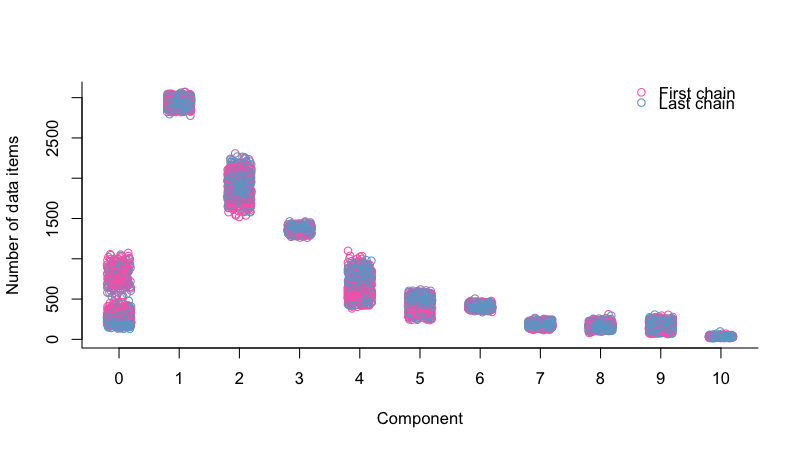

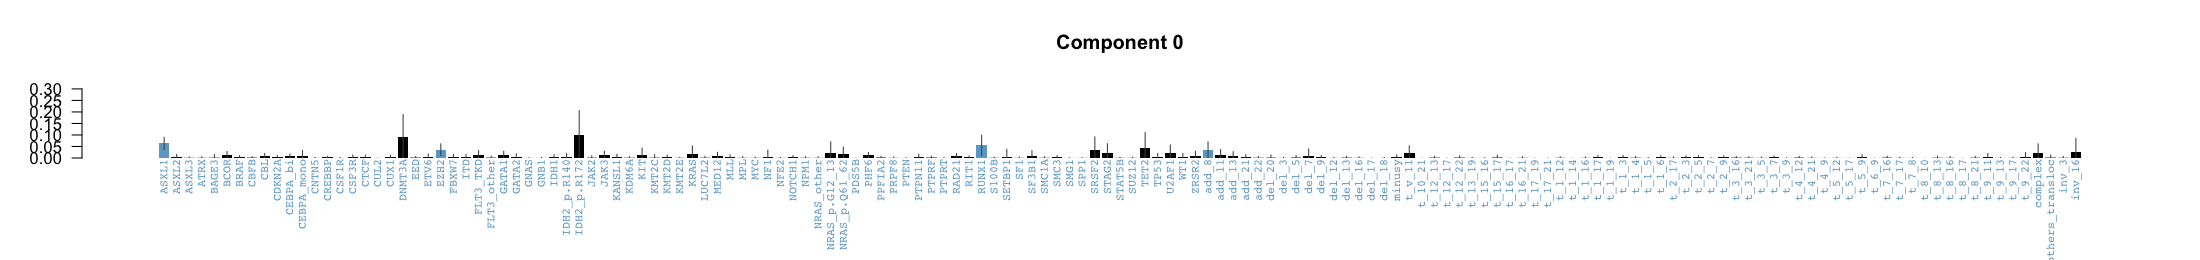

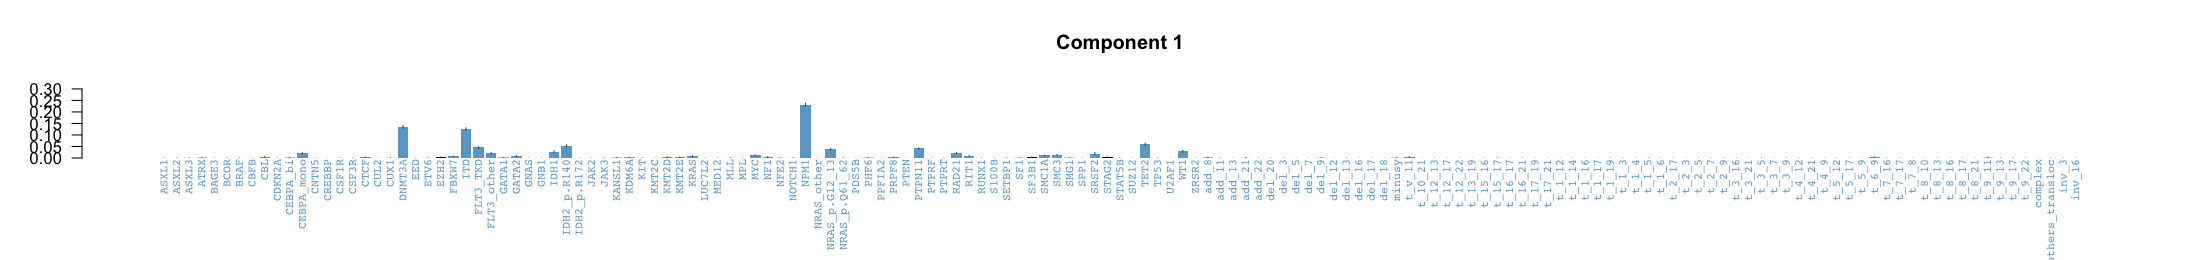

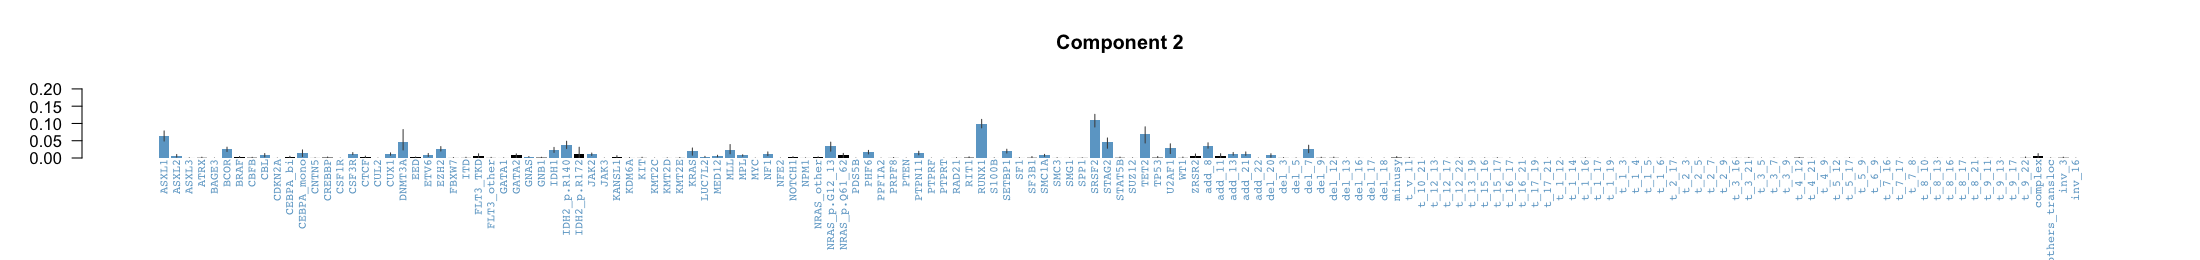

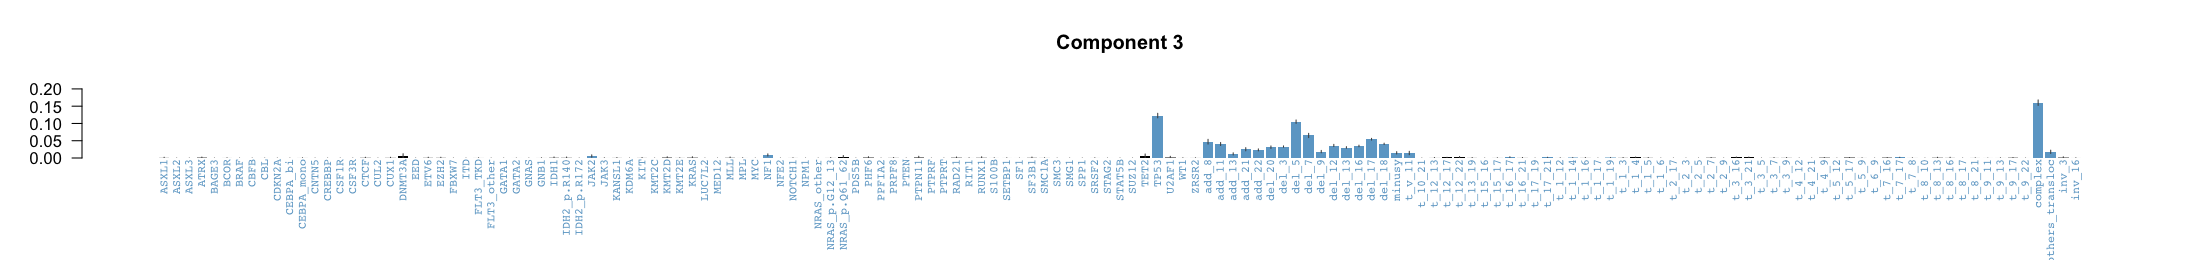

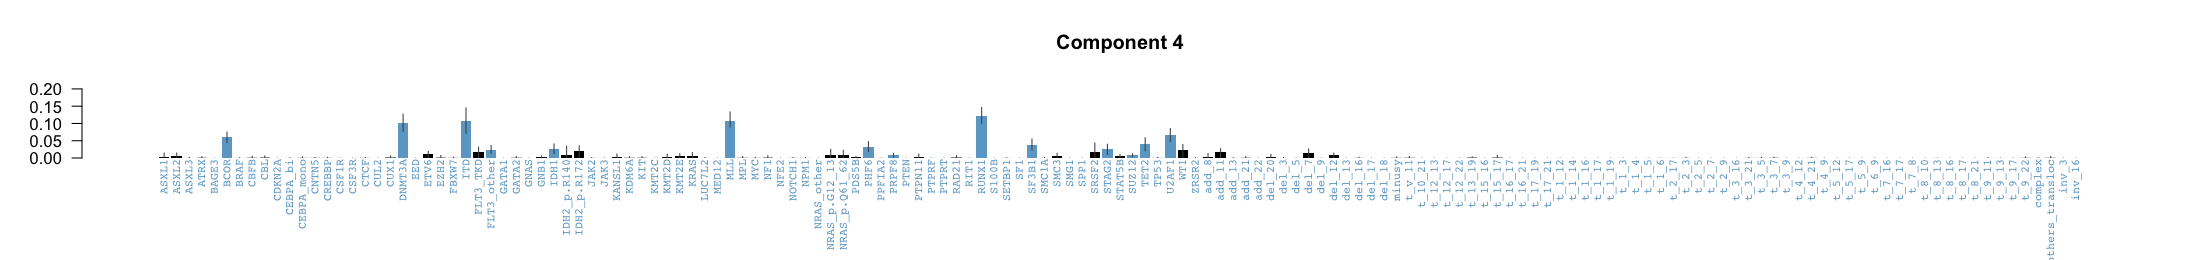

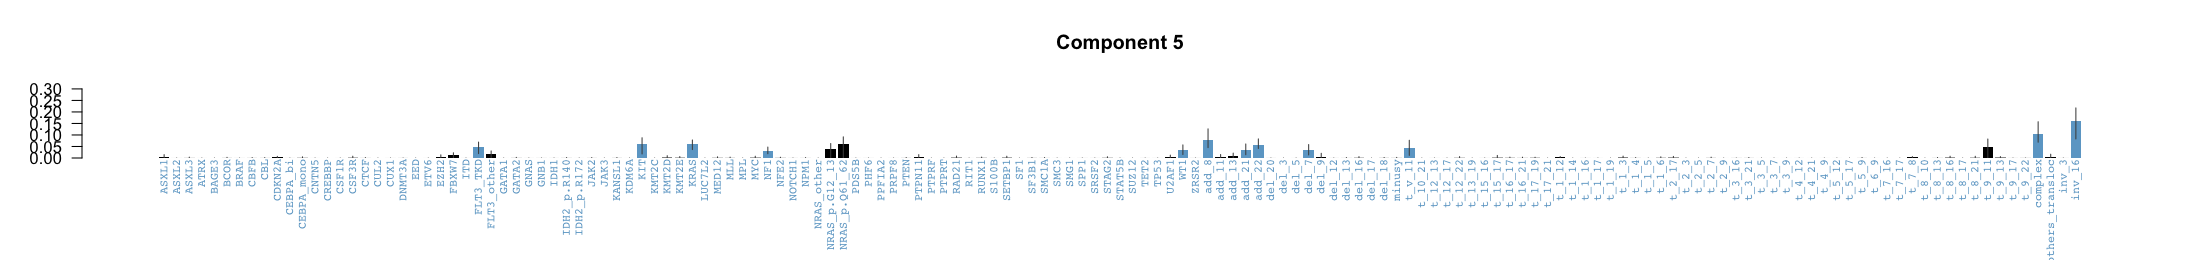

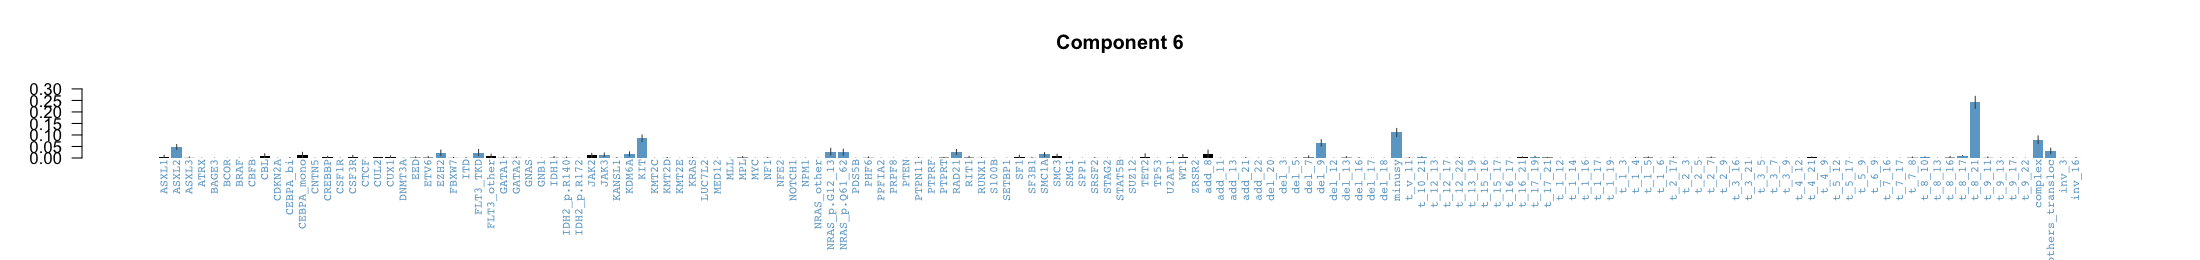

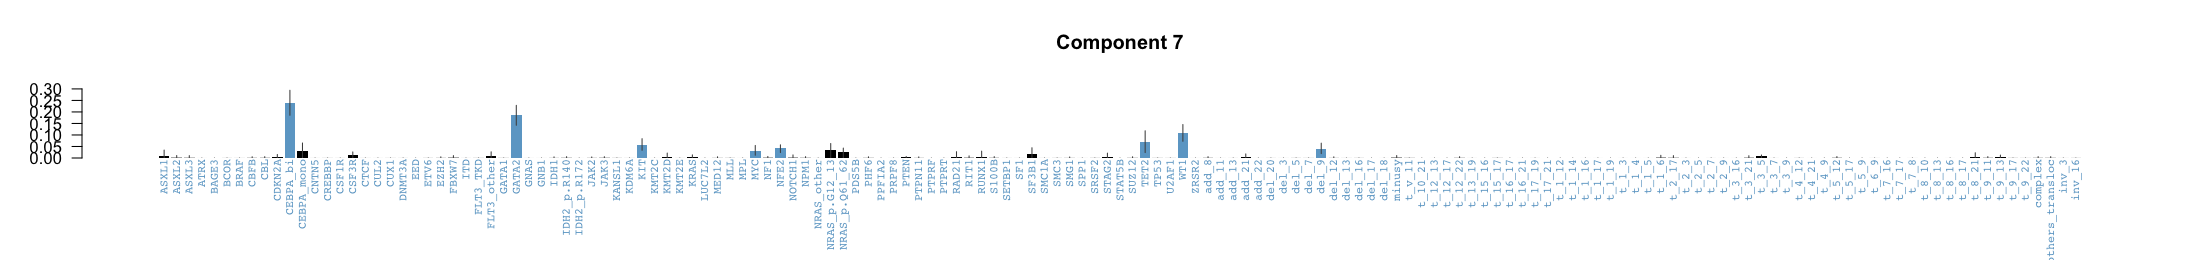

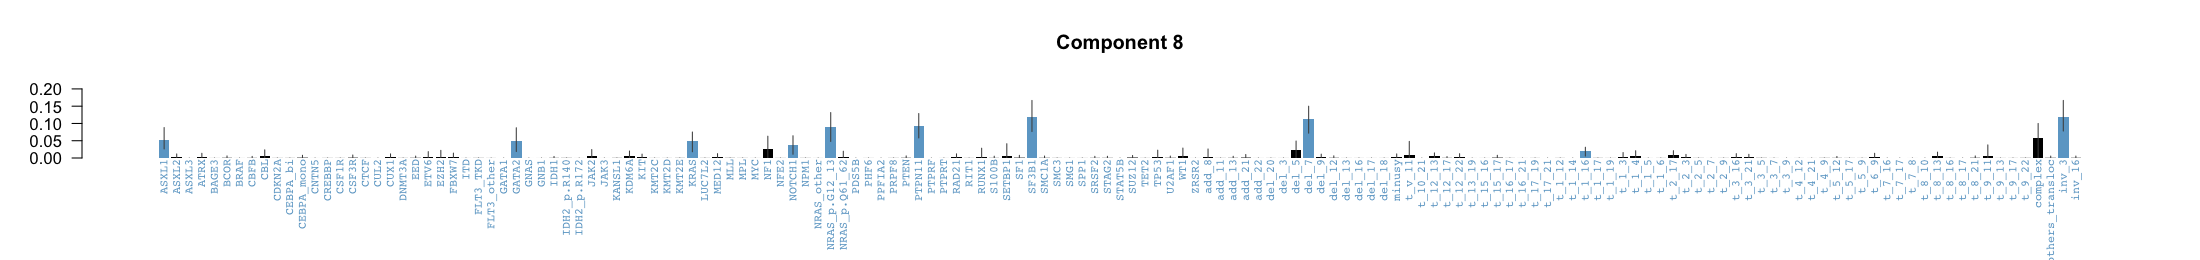

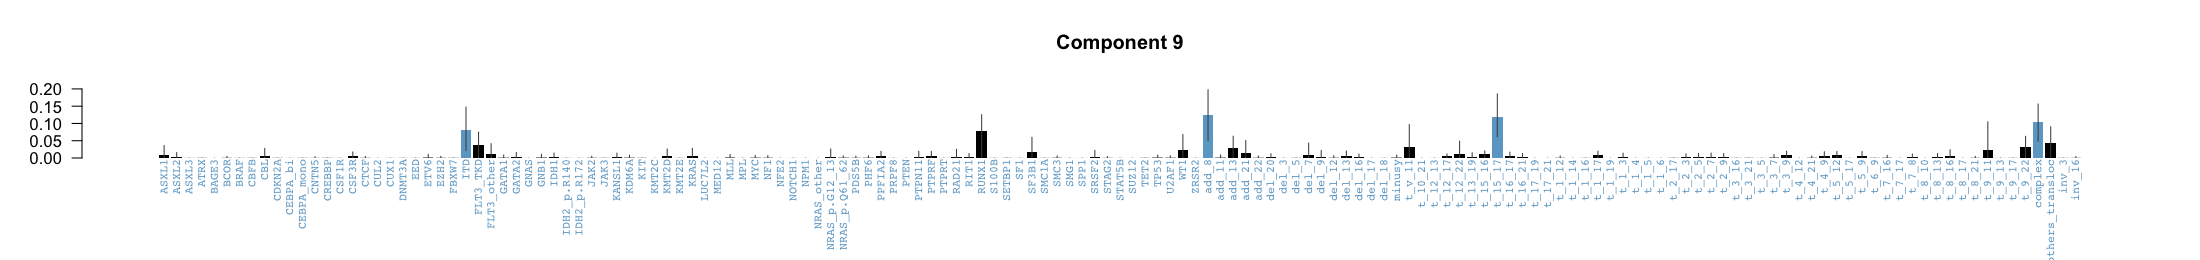

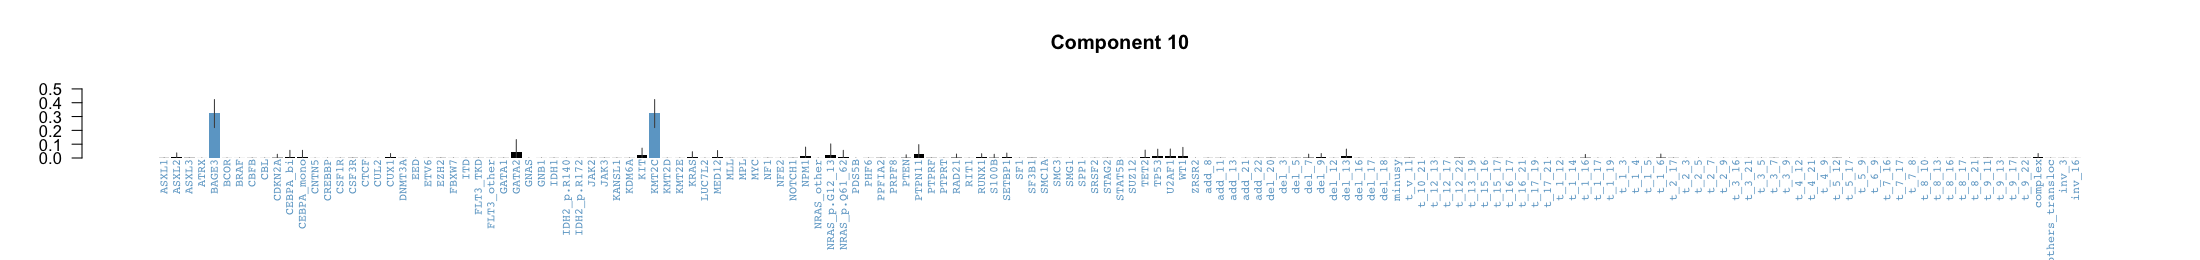

In [62]:
#plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))
plot_components_size(multi_output_cluster_10,8,4.5)
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                                         )

Number of components: 10
Number of NA rows   : 48


values      count freq            
2  1            834  38.7906976744186
3  2            463  21.5348837209302
4  3            227  10.5581395348837
6  5            163  7.58139534883721
5  4            140  6.51162790697674
7  6            113  5.25581395348837
12 NaN           48  2.23255813953488
8  7             46  2.13953488372093
1  0             44  2.04651162790698
9  8             35  1.62790697674419
10 9             31  1.44186046511628
11 10             6  0.27906976744186
13 -- total -- 2150  100%

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


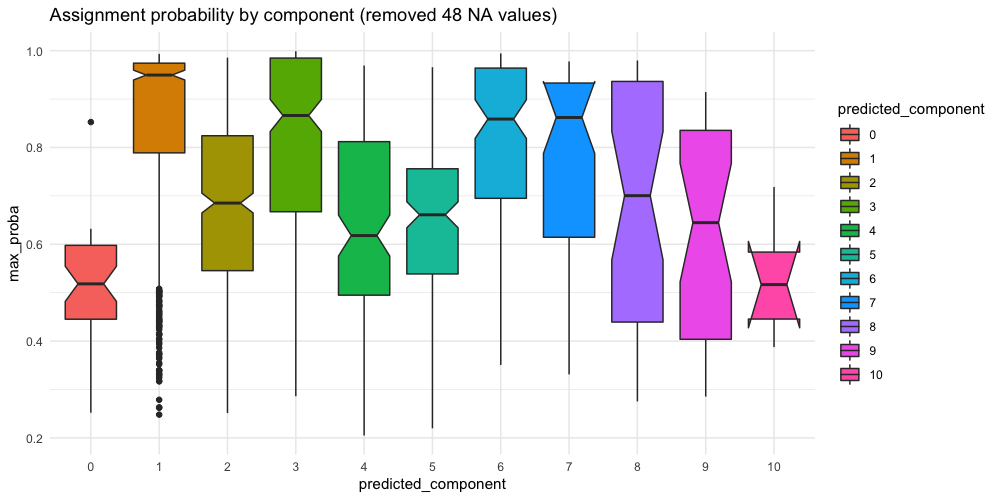

In [63]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])
plot_assignement_probability_by_component(dd_predicted_10_components)

#### People assigned to NaN have no genetic and cytogenetic events (sum=0). We remove them from the analysis

In [11]:
initial_components <- cbind(df_final,add_first_second_predicted_component(multi_output_cluster_10))
sum(rowSums(initial_components[initial_components$predicted_component=="NaN",1:151]))

Number of components: 10
Number of NA rows   : 56


[1] 0

##### Create a dataframe with initial patients and their initial component (without NAN patients)

In [12]:
#write.table(initial_components,file="initial_components_with_proba.tsv",sep='\t')

# STEP 1: DEFINING FEATURES

In [13]:
tmp <- read.table("../finalization_clustering/all_components_with_second_complex_inv3.tsv") # introduce inv_3 for C7 Post Processing
tmp <- tmp[,c(1:150,155,156)]
tmp <- merge(tmp,read.table("initial_components_with_proba.tsv")[,152:166],by=0)
rownames(tmp)<- tmp$Row.names
tmp <- tmp[,-1]
tmp$initial_refined_component <- "not_assigned"
tmp[tmp$NPM1==1,]$initial_refined_component <- "NPM1"
tmp[tmp$initial_refined_component=="not_assigned" & (tmp$TP53==1 & tmp$complex==1),]$initial_refined_component <- "TP53_complex"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==3 & (tmp$TP53==1 | tmp$complex==1),]$initial_refined_component <- "TP53_complex"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & (tmp$t_v_11==1 | tmp$t_9_11==1),]$initial_refined_component <- "t_11"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & (tmp$t_15_17==1),]$initial_refined_component <- "t_15_17"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==6 & (tmp$t_8_21==1),]$initial_refined_component <- "t_8_21"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==7 & (tmp$t_8_21==1),]$initial_refined_component <- "t_8_21"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & (tmp$CEBPA_bi==1),]$initial_refined_component <- "CEBPA_bi"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==9 & (tmp$inv_3==1),]$initial_refined_component <- "inv_3"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==10 & (tmp$BAGE3==1 & tmp$KMT2C==1),]$initial_refined_component <- "BAGE3_KMT2C"

In [14]:
table(tmp$initial_refined_component)


 BAGE3_KMT2C     CEBPA_bi        inv_3 not_assigned         NPM1         t_11 
           6           35            8         1010          682           53 
     t_15_17       t_8_21 TP53_complex 
           9           98          193 

# STEP 2: SECOND MAX PROBA + DEFINING FEATURES

In [15]:
min_proba_NPM1 = min(tmp[tmp$initial_predicted_component==1,]$max_proba)

min_proba_TP53_complex = min(tmp[tmp$initial_predicted_component==3,]$max_proba)

min_proba_transloc = min(tmp[tmp$initial_predicted_component==5,]$max_proba)

min_proba_t_8_21 = min(min(tmp[tmp$initial_predicted_component==6,]$max_proba),min(tmp[tmp$initial_predicted_component==7,]$max_proba))

min_proba_CEBPA_bi = min(tmp[tmp$initial_predicted_component==8,]$max_proba)

min_proba_inv_3 = min(tmp[tmp$initial_predicted_component==9,]$max_proba)

min_proba_BAGE3_KMT2C = min(tmp[tmp$initial_predicted_component==10,]$max_proba)



In [16]:
#refine only the ones not in C0,2,4
tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_refined_component=="not_assigned",c(0,2,4)) ,]$initial_refined_component  <- apply(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_refined_component=="not_assigned",c(0,2,4)),], 1,function(x) {
        if (all(is.na(x['second_predicted_component'])))
            return(NaN)
        else 
            return(ifelse(x['second_predicted_component']==3 & x['second_max_proba']>=0.75*min_proba_TP53_complex & (x['complex']==1 | x["TP53"]==1),"TP53_complex",
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=0.75*min_proba_transloc & (x['t_v_11']==1 | x['t_9_11']==1),"t_11",
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=0.75*min_proba_transloc & x['t_15_17']==1,"t_15_17", 
                   ifelse((x['second_predicted_component']==6 | x['translated_second_predicted_component']==7 ) & x['second_max_proba']>=0.75*min_proba_t_8_21 & x['t_8_21']==1,"t_8_21", 
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=0.75*min_proba_CEBPA_bi & x['CEBPA_bi']==1,"CEBPA_bi",
                   ifelse(x['second_predicted_component']==9 & x['second_max_proba']>=0.75*min_proba_inv_3 & x['inv_3']==1,"inv_3",
                   ifelse(x['second_predicted_component']==10 & x['second_max_proba']>=0.75*min_proba_BAGE3_KMT2C & x['BAGE3']==1 & x['KMT2C']==1,"BAGE3_KMT2C",       
                   "not_assigned"))))))))
    })

# Let's reapply HDP to patients from Initial Component 0,2,4 + patients that do not have defining features from their component and that were not assigned with second max proba (658 from C 0,2,4 and 318 from defining features +second max proba)

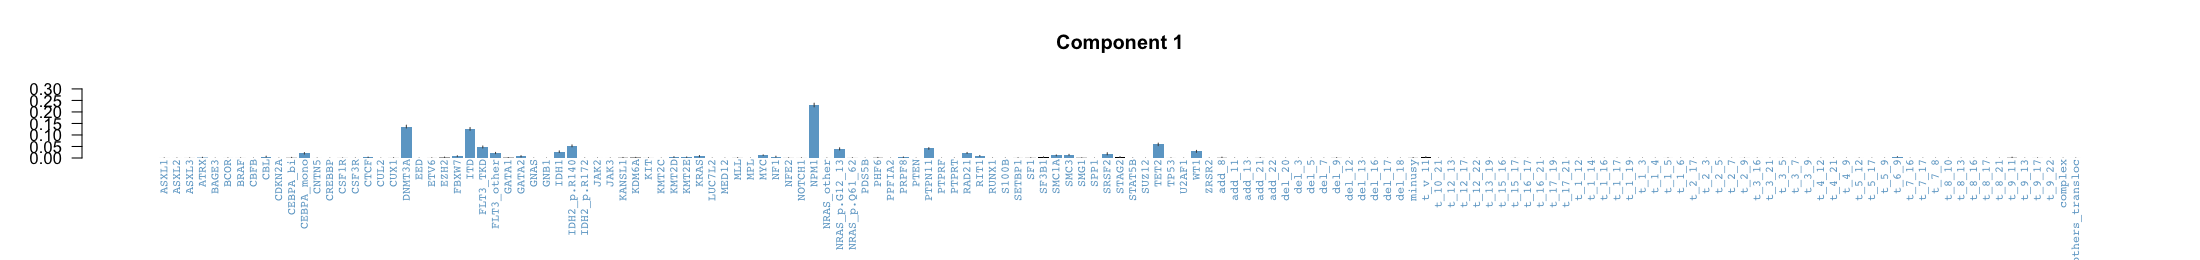

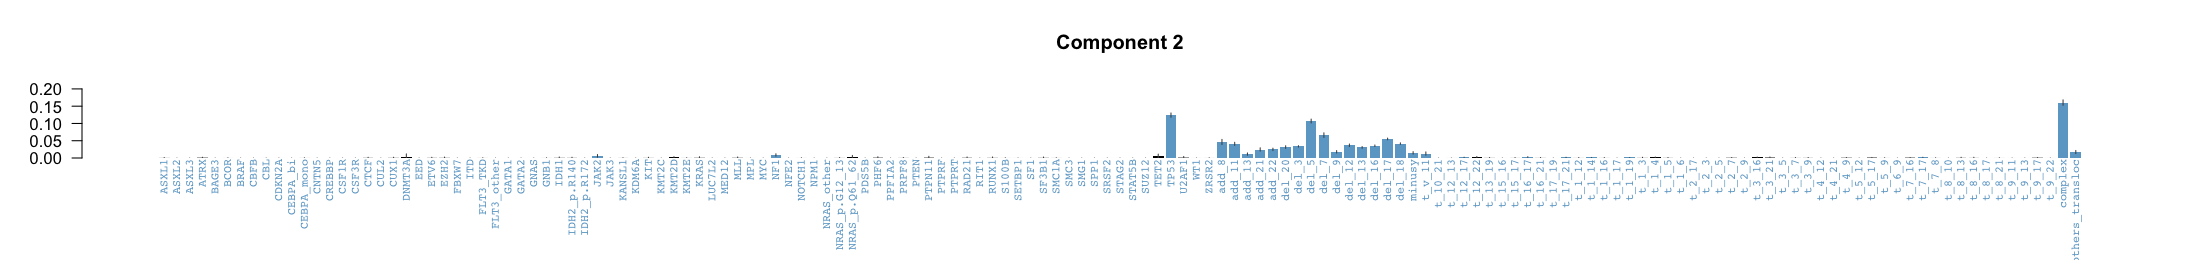

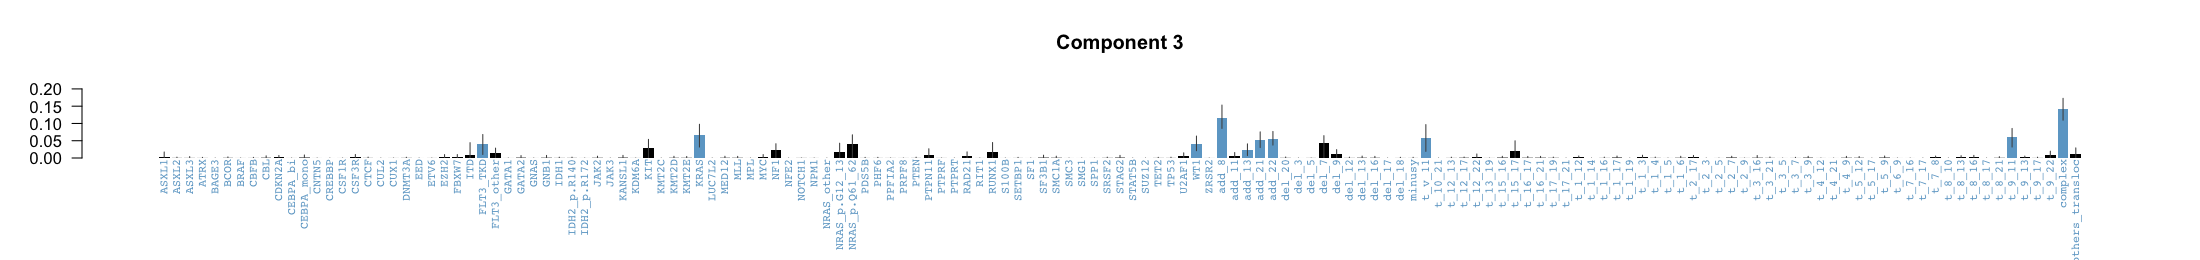

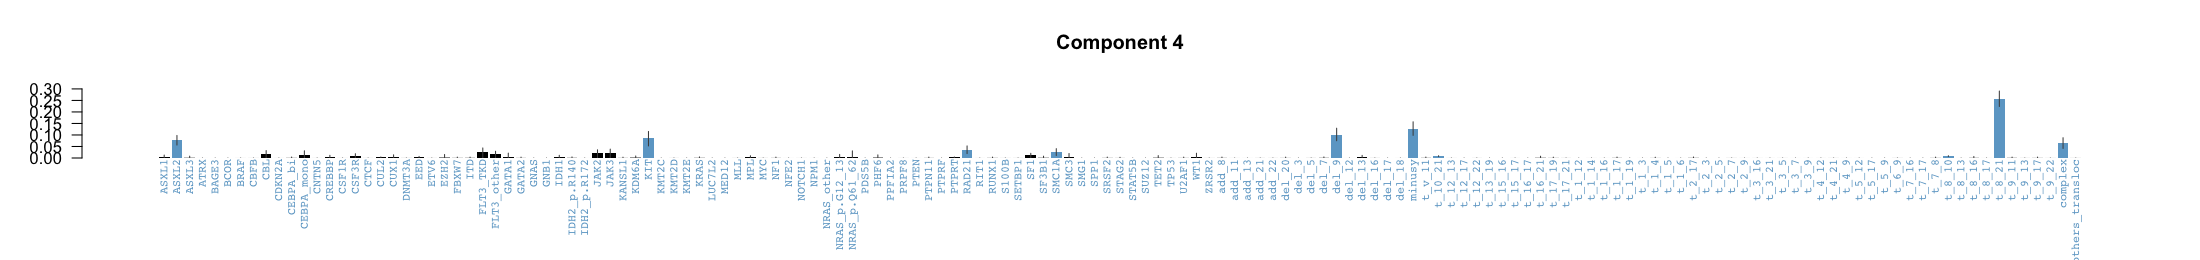

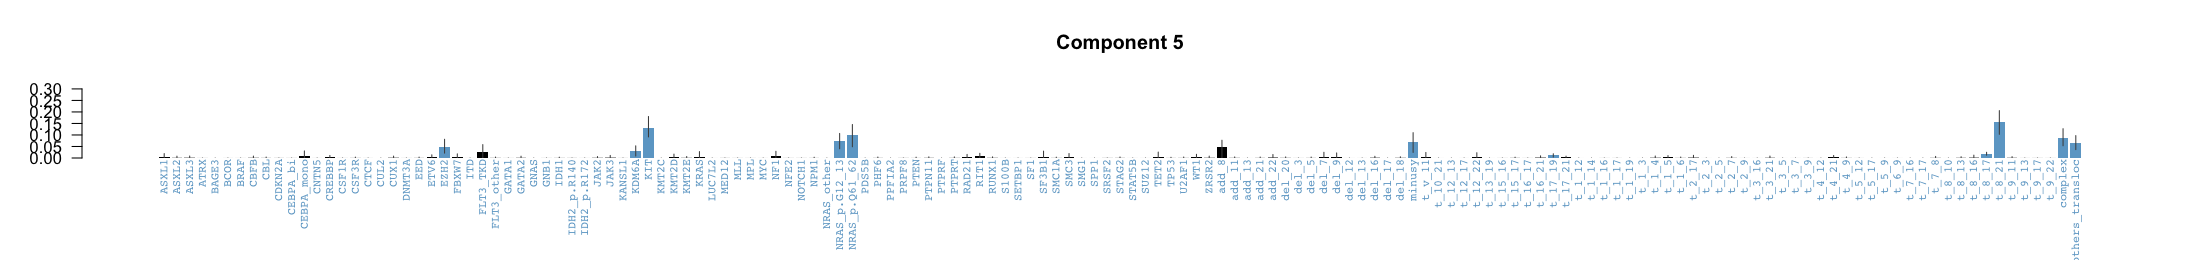

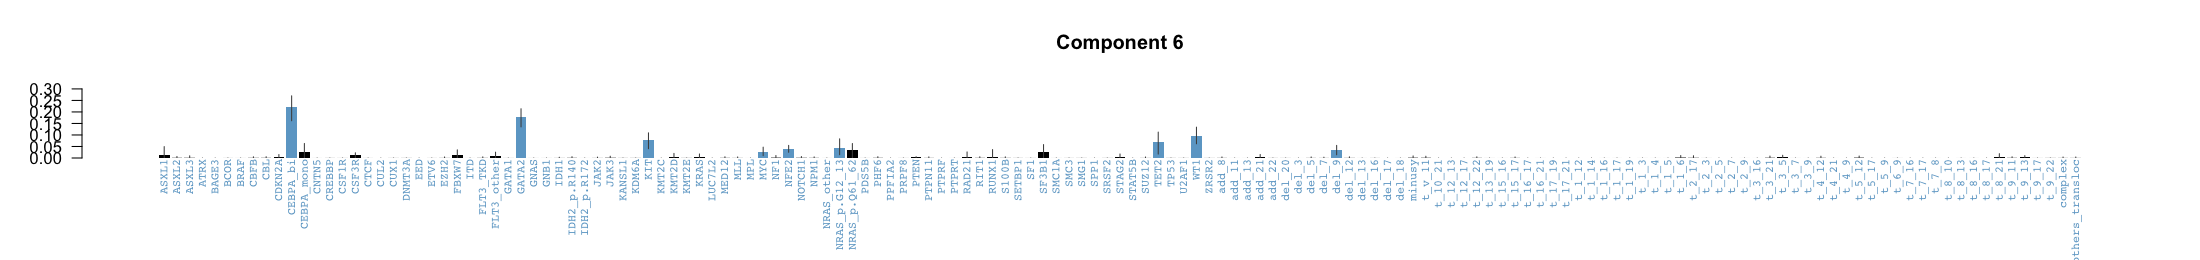

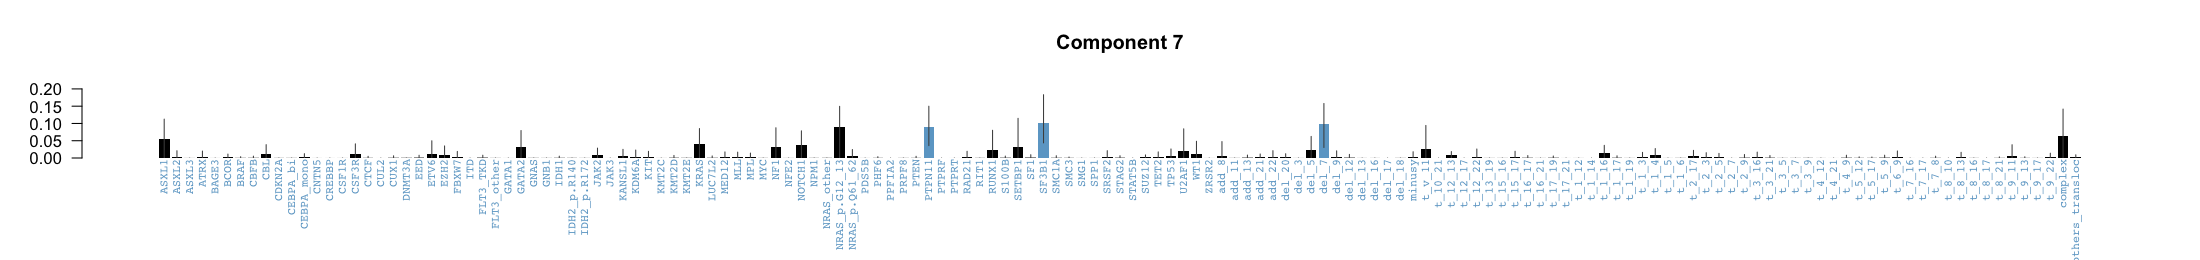

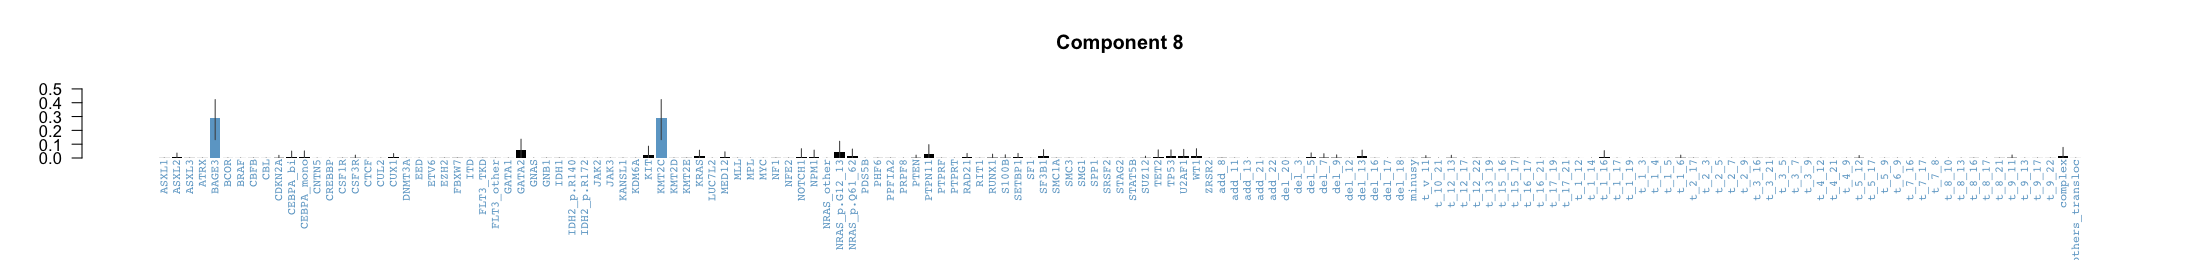

In [17]:
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )

# II- HDP reapplied ON THOSE PATIENTS

In [18]:
# ADD U2AF1 Separation for second HDP

In [25]:
# All dataframe with U2AF1 separation
df <- read.table("../../../data/initial_dataset/1013.mut.csv",sep=',', header = T)
df <- df[df$gene=="U2AF1",c("data_pd","gene","protein")]
df$U2AF1_p.S34 <- ifelse(grepl( "34",df$protein) | grepl( "35",df$protein),1,0)
df$U2AF1_p.Q157 <- ifelse(grepl( "157",df$protein) | grepl( "156",df$protein),1,0)
df <- unique(df,by="data_pd")
newd <-  df %>% group_by(data_pd) %>% filter(n()>1)
tmp1 <- data.frame(data_pd=unique(newd$data_pd),gene=rep("U2AF1",length(unique(newd$data_pd))),protein=rep("p",length(unique(newd$data_pd))),U2AF1_p.S34=rep(0,length(unique(newd$data_pd))),U2AF1_p.Q157=rep(0,length(unique(newd$data_pd))))
for (element in unique(newd$data_pd)){    
    tmp1[tmp1$data_pd==element,]$U2AF1_p.S34 <- colSums(newd[newd$data_pd==element,"U2AF1_p.S34"])
    tmp1[tmp1$data_pd==element,]$U2AF1_p.Q157 <- colSums(newd[newd$data_pd==element,"U2AF1_p.Q157"])
}
df <- rbind(df[!is.element(df$data_pd,unique(newd$data_pd)),c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")],tmp1[,c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")])
rownames(df)<- df$data_pd
df_u2af1 <- df[,c("U2AF1_p.S34","U2AF1_p.Q157")]
tmp_u2af1 <- merge(tmp,df_u2af1,by=0,all.x=T)
rownames(tmp_u2af1) <- tmp_u2af1$Row.names
tmp_u2af1 <- tmp_u2af1[,c(2:81,170,171,83:153,169)]
tmp_u2af1[is.na(tmp_u2af1)] <- 0

In [26]:
df_to_recluster <- tmp[tmp$initial_refined_component=="not_assigned",c(1:149,151,150)] # to keep same order as first HDP and remove complex
df_to_recluster <- tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",c(1:150,152,151)]


In [27]:
# write.table(df_to_recluster,"df_to_recluster.tsv")

In [28]:
num_cols = ncol(df_to_recluster[colSums(df_to_recluster) > 0])  ## keep only column that have at least a mutation
num_cols
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],bin))
gaussian <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],normal))
pois <- as.numeric(unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],poisson)))
unif <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],equally))

[1] 132

In [29]:
data <- df_to_recluster[colSums(df_to_recluster) > 0]
posterior_samples <- 150
initial_clusters <- 5
burn <- 5000
chains <- 3
base_dist <- gaussian
aa <- 1
ab <-1
multi_output <- launch(df_to_recluster[colSums(df_to_recluster) > 0],base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_recluster_7 <- extract_components(multi_output)


Initialise HDP on a 974 x 132 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 450 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 975 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of da

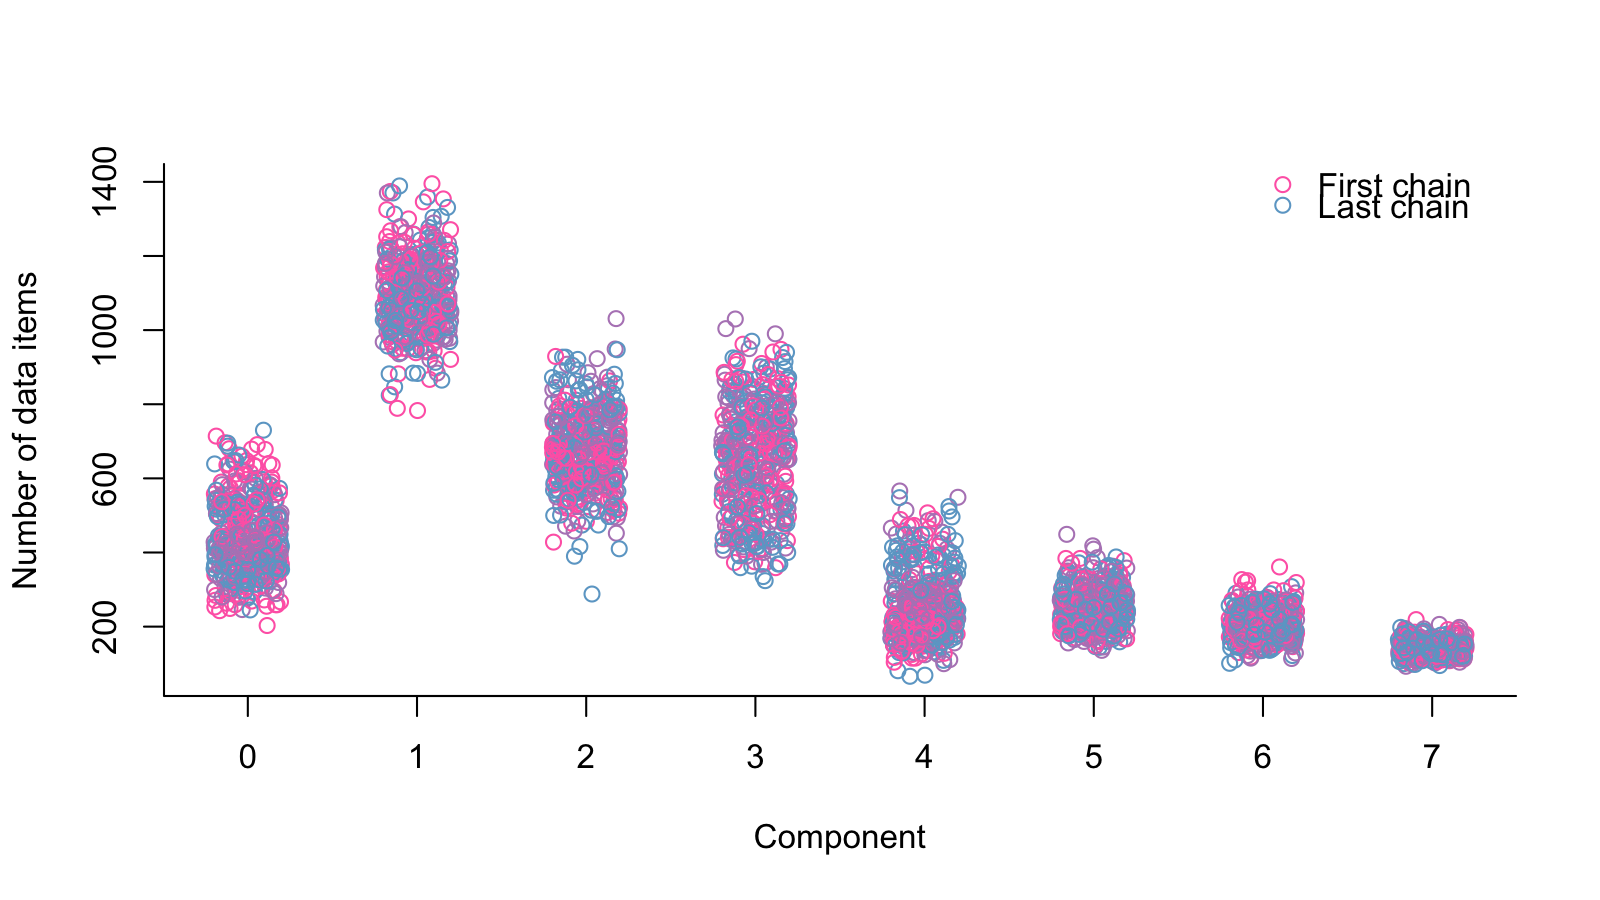

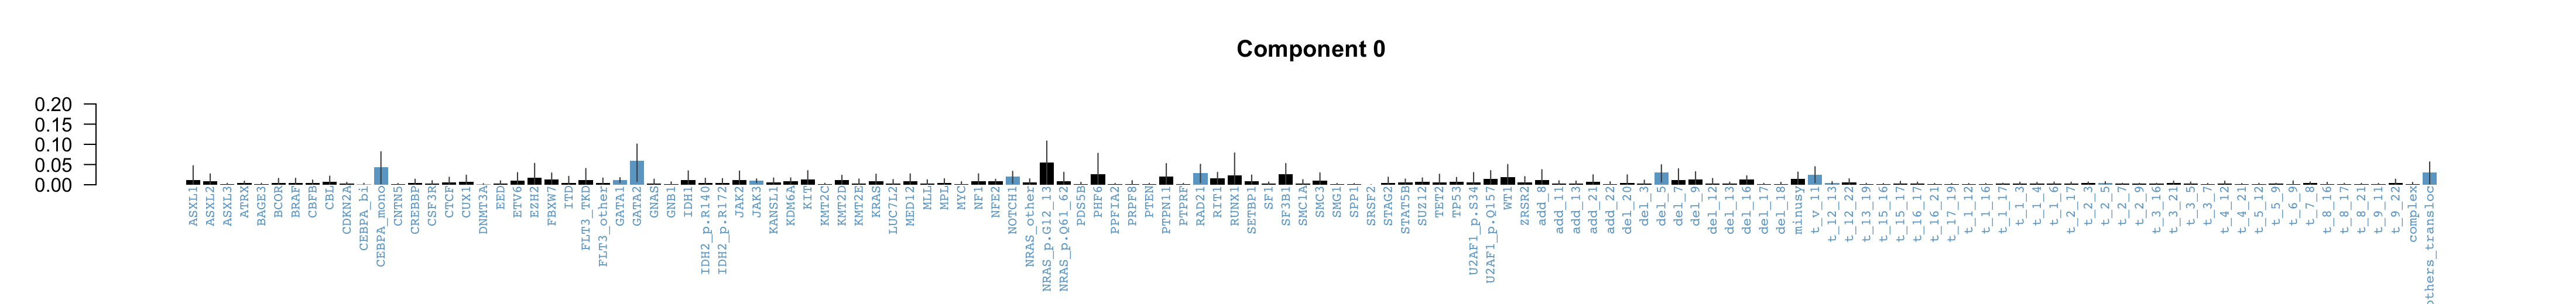

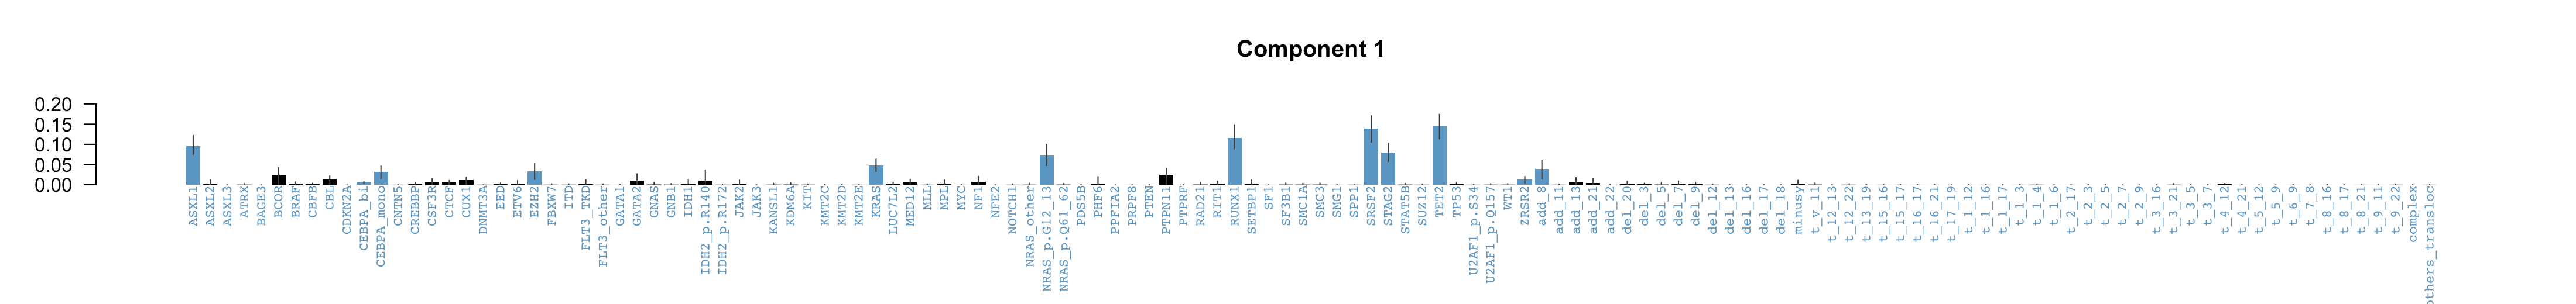

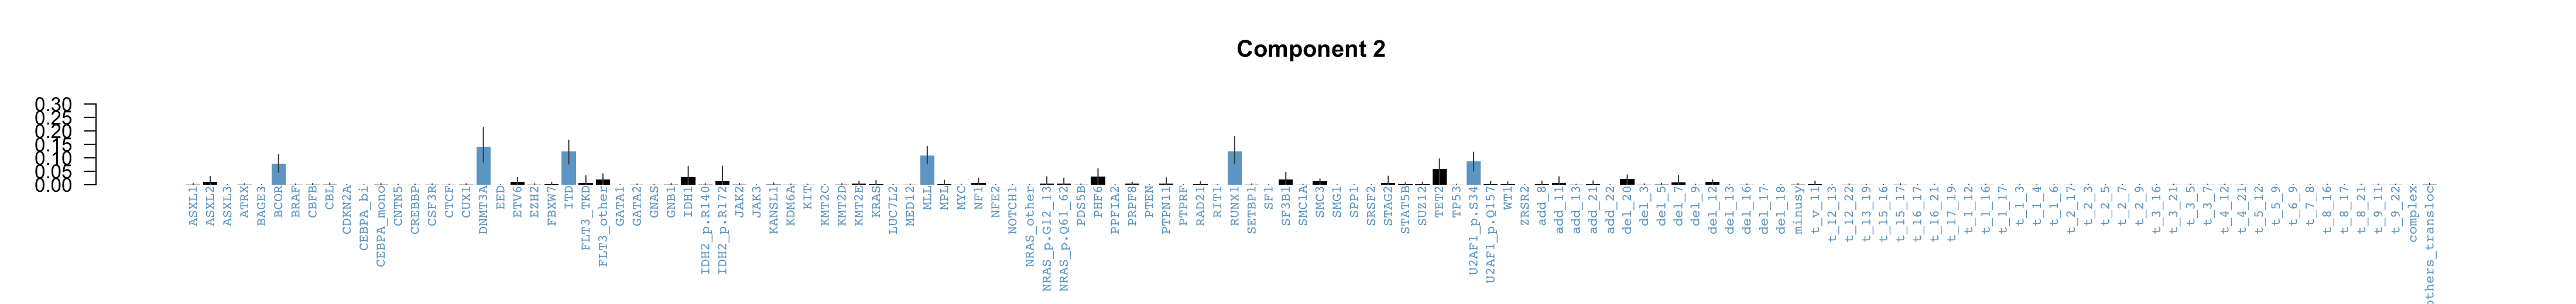

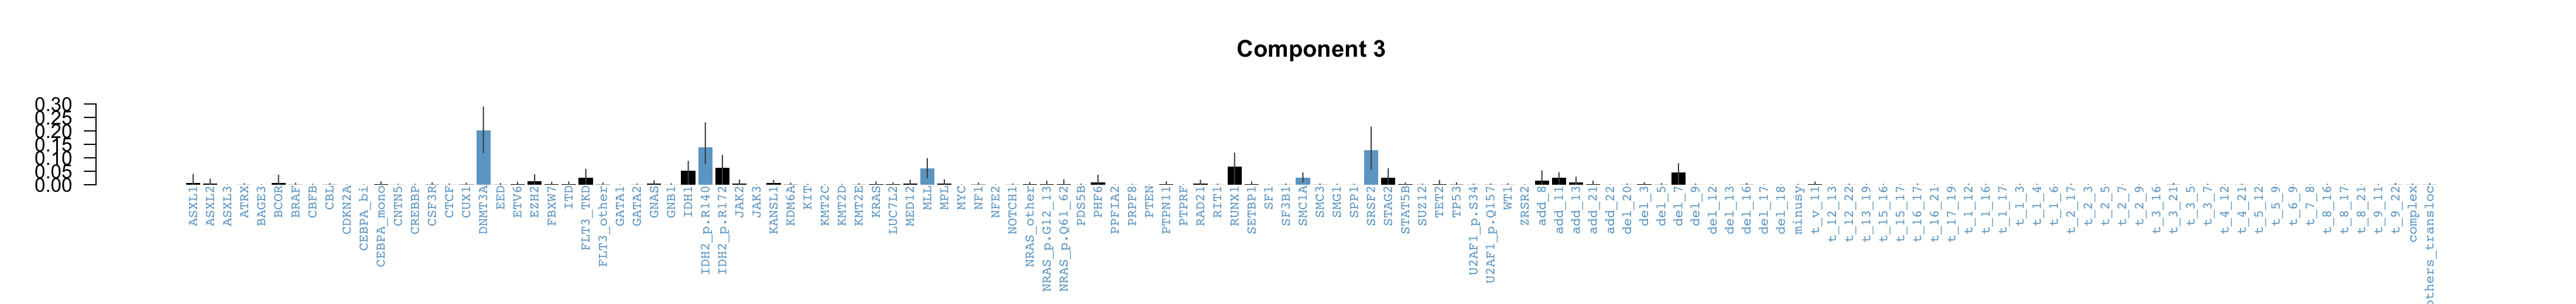

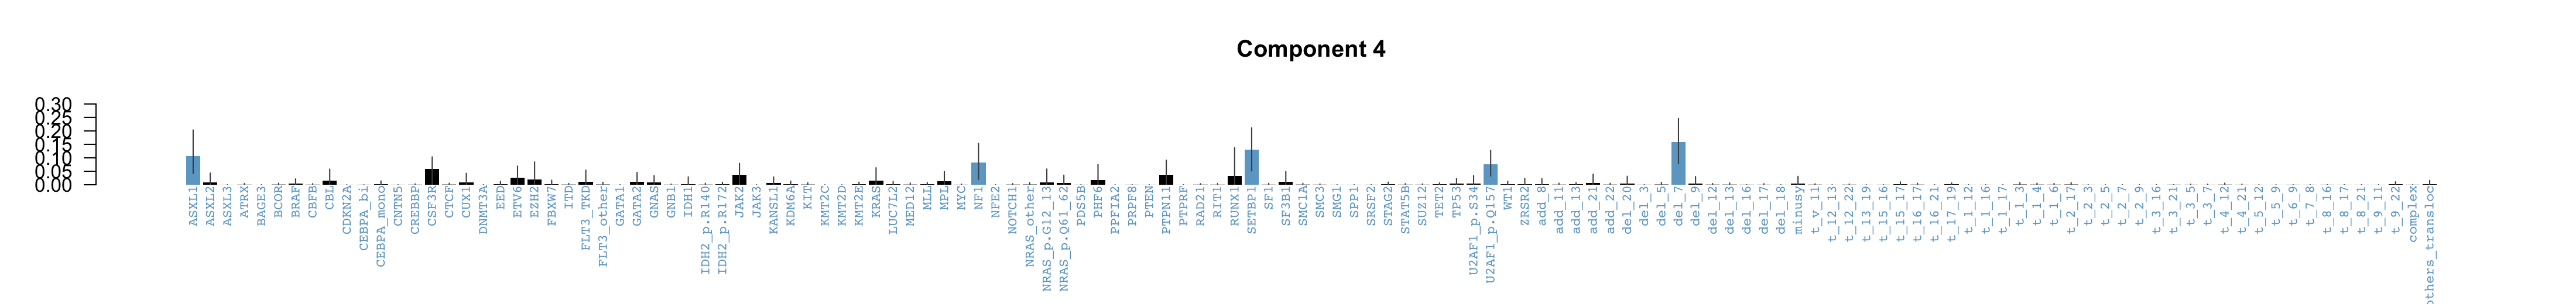

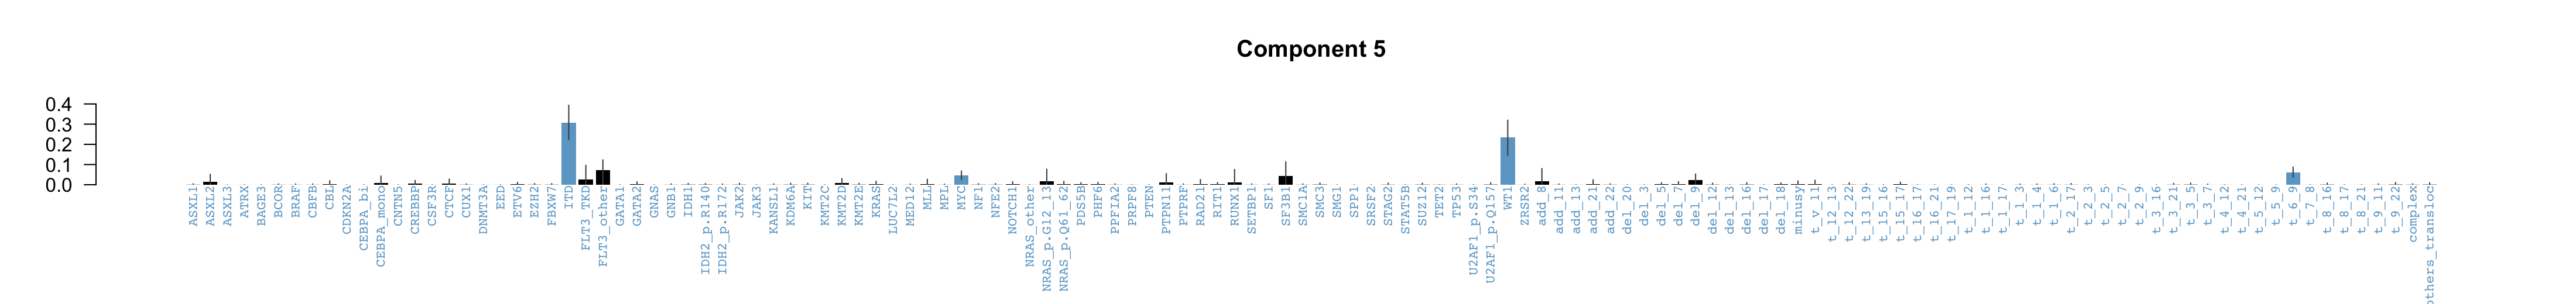

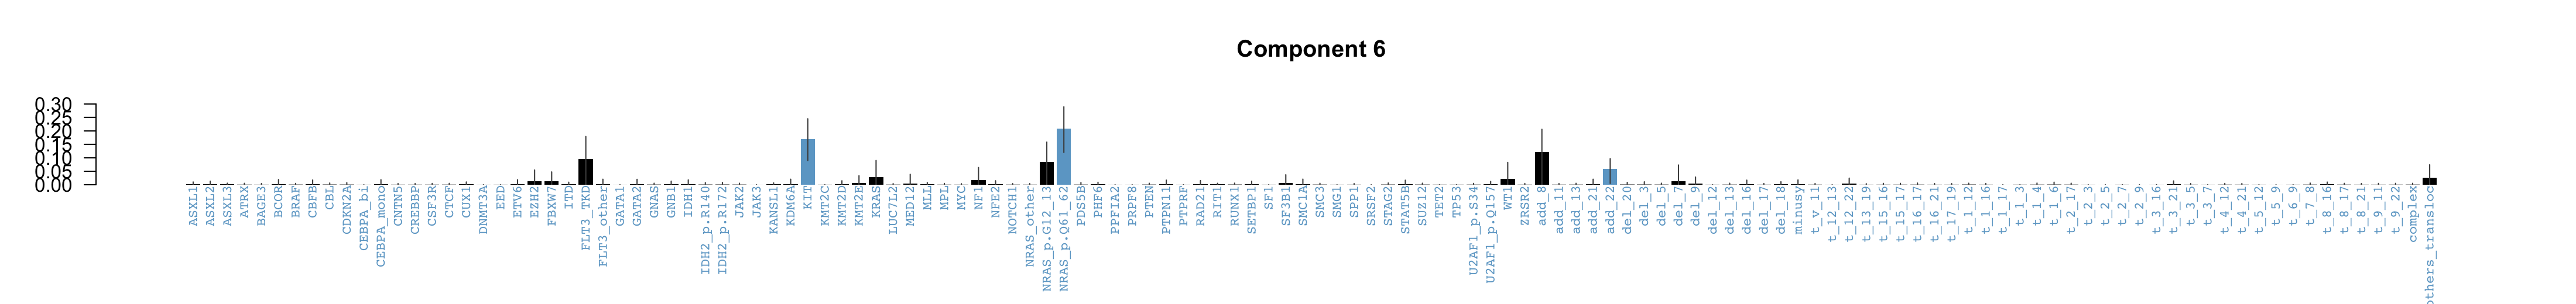

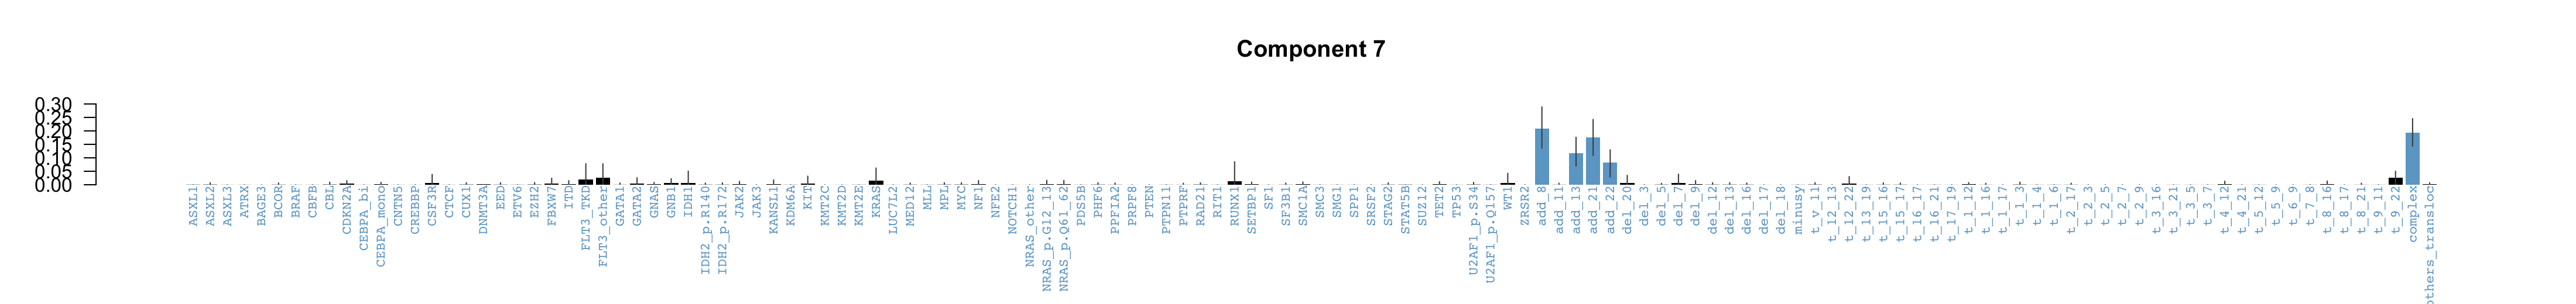

In [104]:
plot_components_size(multi_output_recluster_7,8,4.5)
set_notebook_plot_size(22,2.6)
plot_comp_distn(multi_output_recluster_7,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black")



Number of components: 7
Number of NA rows   : 3


values      count freq             
2  1           291   29.8767967145791 
4  3           185   18.993839835729  
3  2           171   17.5564681724846 
1  0           106   10.8829568788501 
6  5            75   7.70020533880903 
7  6            71   7.28952772073922 
5  4            44   4.51745379876797 
8  7            28   2.87474332648871 
9  NaN           3   0.308008213552361
11 -- total -- 974   100%

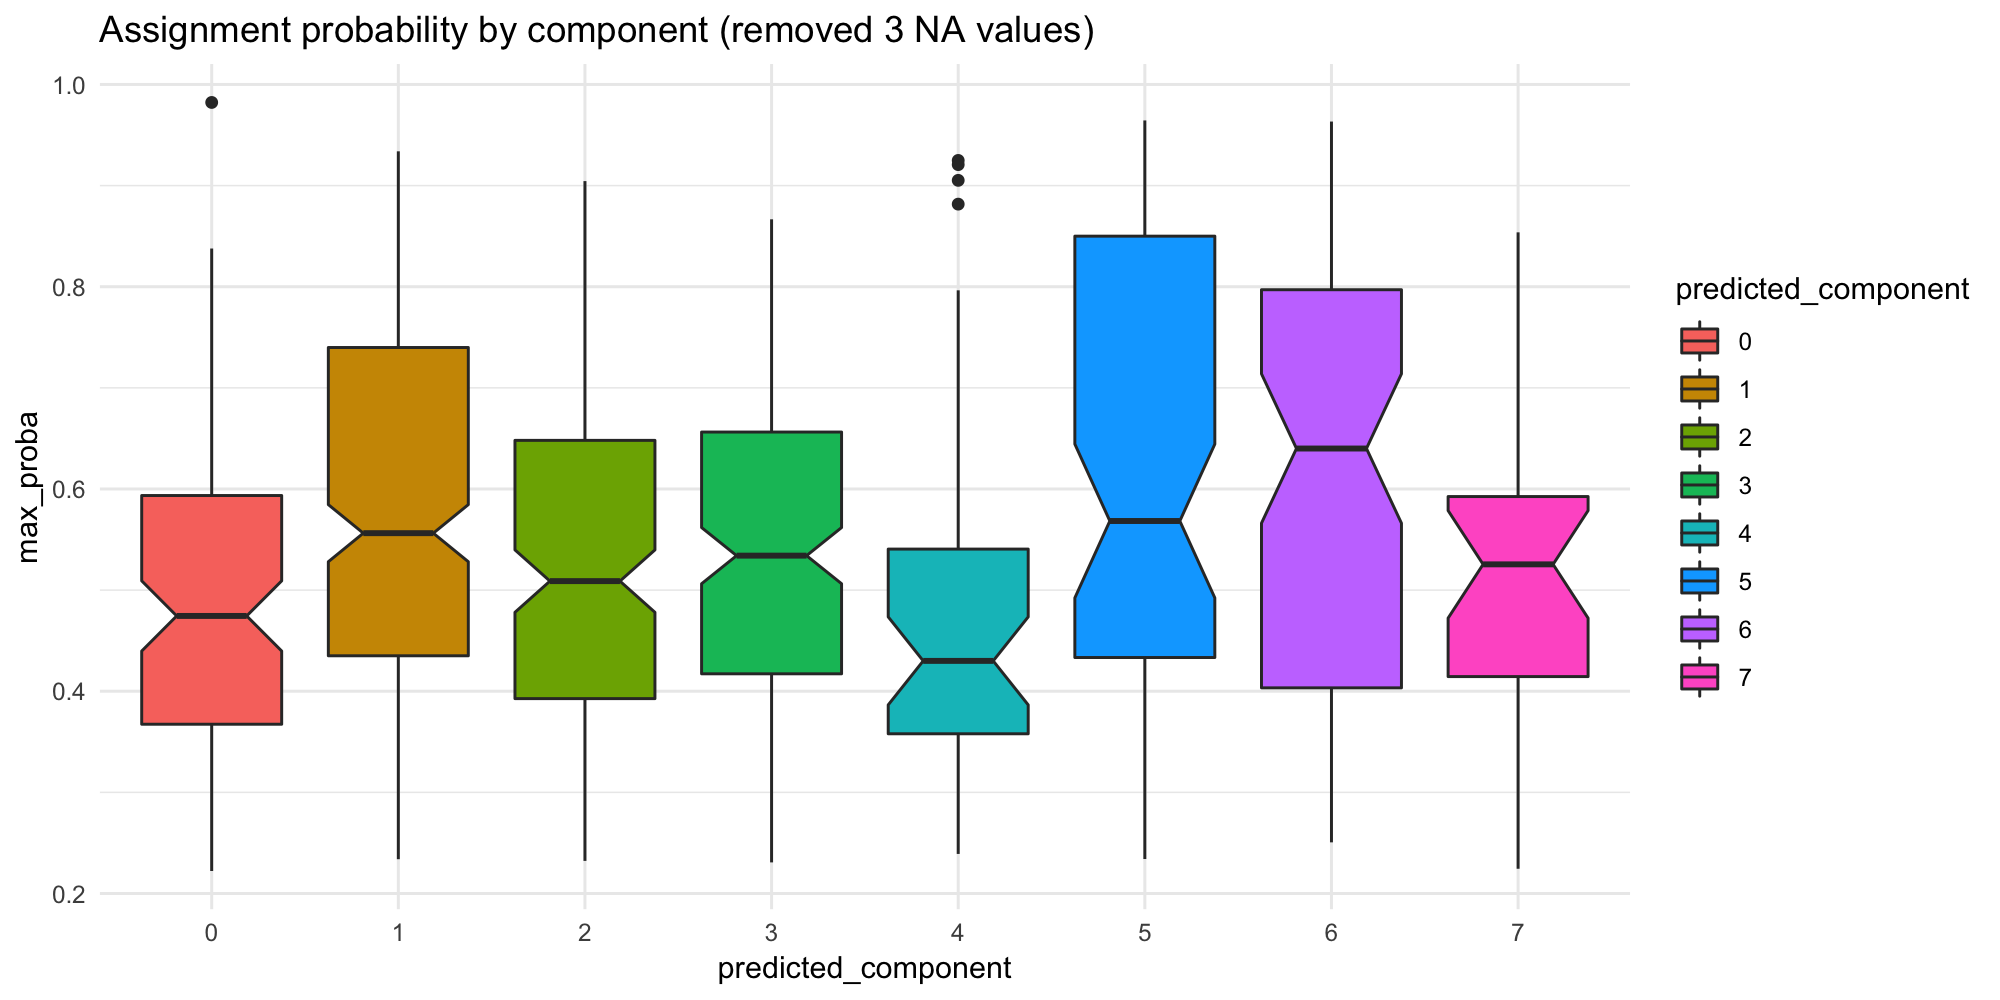

In [105]:
dd_predicted_recluster_7 <- get_prediction_result_dataframe(multi_output_recluster_7, df_to_recluster[colSums(df_to_recluster) > 0])
get_table(dd_predicted_recluster_7[,'predicted_component'])
plot_assignement_probability_by_component(dd_predicted_recluster_7)

# Refining Second HDP with defining features and second max proba

#### High second_hdp_second_max_proba for patients in component 0 so it's a good motivation for reassignment with second max proba!

# STEP 1 Second HDP: DEFINING FEATURES WITHIN COMPONENTS

In [215]:
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
second_hdp_probas <- add_first_second_predicted_component(multi_output_recluster_7)
colnames(second_hdp_probas) <- paste("second_hdp", colnames(second_hdp_probas), sep = "_")  # to not interfer with proba from first HDP
tmp_hdp_2 <- cbind(tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",],second_hdp_probas)
tmp_hdp_2 <- na.omit(tmp_hdp_2)
#write.table(tmp_hdp_2,"second_hdp_components_with_probas.tsv")


Number of components: 7
Number of NA rows   : 3


In [216]:
for (comp in c(0,1,2,4)){    
    tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==comp & (rowSums(tmp_hdp_2[,factors])>1),"initial_refined_component"] <- "chr_splicing_multiple"
    tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==comp & (rowSums(tmp_hdp_2[,factors])==1),"initial_refined_component"] <- "chr_splicing_1"
    }
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==3 & tmp_hdp_2$DNMT3A==1 &(tmp_hdp_2$IDH1==1 | tmp_hdp_2$IDH2_p.R140==1 | tmp_hdp_2$IDH2_p.R172==1) ,]$initial_refined_component <- "DNMT3A_IDH1_2"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5 & (tmp_hdp_2$WT1==1 | tmp_hdp_2$t_6_9==1) ,]$initial_refined_component <- "WT1_t_6_9_ITD"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==6 & tmp_hdp_2$KIT==1 & (tmp_hdp_2$NRAS_p.G12_13==1  | tmp_hdp_2$NRAS_p.Q61_62==1),]$initial_refined_component <- "KIT_NRAS"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==7 & (tmp_hdp_2$add_8==1 | tmp_hdp_2$add_13==1 | tmp_hdp_2$add_21==1 | tmp_hdp_2$add_22==1),]$initial_refined_component <- "additions"

In [217]:
table(tmp_hdp_2$initial_refined_component)


            additions        chr_splicing_1 chr_splicing_multiple 
                   25                   131                   351 
        DNMT3A_IDH1_2              KIT_NRAS          not_assigned 
                   94                    10                   307 
        WT1_t_6_9_ITD 
                   53 

# STEP 2 Second HDP: SECOND MAX PROBA + defining lesions

In [218]:
min_proba_chr_splicing = min(min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==1,]$second_hdp_max_proba),min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==2,]$second_hdp_max_proba),
                             min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==4,]$second_hdp_max_proba))

min_proba_DNMT3A_IDH1_2 = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==3,]$second_hdp_max_proba)

min_proba_WT1_t_6_9_ITD = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5,]$second_hdp_max_proba)

min_proba_KIT_NRAS = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==6,]$second_hdp_max_proba)

min_proba_additions = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==7,]$second_hdp_max_proba)

In [219]:
tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" & is.element(tmp_hdp_2$second_hdp_second_predicted_component,c(0,1,2,4))
          & tmp_hdp_2$second_hdp_second_max_proba>=0.75*min_proba_chr_splicing & rowSums(tmp_hdp_2[,factors])>1,]$initial_refined_component <- "chr_splicing_multiple"

tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" & is.element(tmp_hdp_2$second_hdp_second_predicted_component,c(0,1,2,4))
          & tmp_hdp_2$second_hdp_second_max_proba>=0.75*min_proba_chr_splicing & rowSums(tmp_hdp_2[,factors])==1,]$initial_refined_component <- "chr_splicing_1"

tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" ,]$initial_refined_component  <- apply(tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" ,], 1,function(x) {
        if (all(is.na(x['second_hdp_second_predicted_component'])))
            return(NaN)
        else 
            return(
                   ifelse(x['second_hdp_second_predicted_component']==3 & x['second_hdp_second_max_proba']>=0.75*min_proba_DNMT3A_IDH1_2 & (x['DNMT3A']==1 & (x['IDH1']==1 | x['IDH2_p.R140']==1  | x['IDH2_p.R172']==1)),"DNMT3A_IDH1_2",
                   ifelse(x['second_hdp_second_predicted_component']==5 & x['second_hdp_second_max_proba']>=0.75*min_proba_WT1_t_6_9_ITD & (x['WT1']==1 | x['t_6_9']==1),"WT1_t_6_9_ITD", 
                   ifelse(x['second_hdp_second_predicted_component']==6 & x['second_hdp_second_max_proba']>=0.75*min_proba_KIT_NRAS & (x["KIT"]==1 & (x["NRAS_p.G12_13"]==1  | x["NRAS_p.Q61_62"]==1)),"KIT_NRAS",
                   ifelse(x['second_hdp_second_predicted_component']==7 & x['second_hdp_second_max_proba']>=0.75*min_proba_additions & (x['add_8']==1 | x['add_13']==1 | x['add_21']==1 | x['add_22']==1),"additions",      
                   "not_assigned")))))
    })

In [220]:
table(tmp_hdp_2$initial_refined_component)


            additions        chr_splicing_1 chr_splicing_multiple 
                   32                   164                   386 
        DNMT3A_IDH1_2              KIT_NRAS          not_assigned 
                   94                    11                   222 
        WT1_t_6_9_ITD 
                   62 

# STEP 3: Merge HDP 1 and HDP 2 and try defining lesions

In [221]:
tmp_hdp_1 <- tmp_u2af1[tmp_u2af1$initial_refined_component !="not_assigned",]
df_final_with_comp <- rbind(tmp_hdp_1,tmp_hdp_2[,1:154])

In [222]:
table(df_final_with_comp$initial_refined_component)


            additions           BAGE3_KMT2C              CEBPA_bi 
                   32                     6                    40 
       chr_splicing_1 chr_splicing_multiple         DNMT3A_IDH1_2 
                  164                   386                    94 
                inv_3              KIT_NRAS          not_assigned 
                   10                    11                   222 
                 NPM1                  t_11               t_15_17 
                  682                    64                    17 
               t_8_21          TP53_complex         WT1_t_6_9_ITD 
                   99                   202                    62 

In [223]:
df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_8_21==1,]$initial_refined_component

character(0)

In [224]:
try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & (df_final_with_comp$t_9_11==1 | df_final_with_comp$t_v_11==1),]$initial_refined_component <- "t_11")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_15_17==1,]$initial_refined_component <- "t_15_17")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_8_21==1,]$initial_refined_component <- "t_8_21")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$CEBPA_bi==1,]$initial_refined_component <- "CEBPA_bi")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$inv_3==1,]$initial_refined_component <- "inv_3")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$BAGE3==1 & df_final_with_comp$KMT2C==1,]$initial_refined_component <- "BAGE3_KMT2C")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & rowSums(df_final_with_comp[,factors])>1,]$initial_refined_component <- "chr_splicing_multiple")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$DNMT3A==1 &
                   (df_final_with_comp$IDH1==1 | df_final_with_comp$IDH2_p.R140==1 | df_final_with_comp$IDH2_p.R172==1),]$initial_refined_component <- "DNMT3A_IDH1_2")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & (df_final_with_comp$WT1==1 | df_final_with_comp$t_6_9==1 ),]$initial_refined_component <- "WT1_t_6_9_ITD")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$KIT==1 &
                   (df_final_with_comp$NRAS_p.G12_13==1 | df_final_with_comp$NRAS_p.Q61_62==1),]$initial_refined_component <- "KIT_NRAS")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & 
                       (df_final_with_comp$add_8==1 | df_final_with_comp$add_13==1 | df_final_with_comp$add_21==1 | df_final_with_comp$add_22==1) ,]$initial_refined_component <- "additions")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & rowSums(df_final_with_comp[,factors])==1,]$initial_refined_component <- "chr_splicing_1")

table(df_final_with_comp$initial_refined_component)

Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "t_8_21") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "CEBPA_bi") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "BAGE3_KMT2C") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "KIT_NRAS") : 
  replacement has 1 row, data has 0



            additions           BAGE3_KMT2C              CEBPA_bi 
                   63                     6                    40 
       chr_splicing_1 chr_splicing_multiple         DNMT3A_IDH1_2 
                  166                   394                    95 
                inv_3              KIT_NRAS          not_assigned 
                   13                    11                   161 
                 NPM1                  t_11               t_15_17 
                  682                    74                    18 
               t_8_21          TP53_complex         WT1_t_6_9_ITD 
                   99                   202                    67 

#Let's look at the repartition of initial component 0,2 and 4 in their new HDP Clustering : new component 1 to 7

In [225]:
# Final table with Components
df_final_with_comp$final_component_numeric <- ifelse(df_final_with_comp$initial_refined_component=="NPM1",1,
                                              ifelse(df_final_with_comp$initial_refined_component=="TP53_complex",2, 
                                              ifelse(df_final_with_comp$initial_refined_component=="t_11",3,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_15_17",4,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_8_21",5,
                                              ifelse(df_final_with_comp$initial_refined_component=="CEBPA_bi",6, 
                                              ifelse(df_final_with_comp$initial_refined_component=="inv_3",7,
                                              ifelse(df_final_with_comp$initial_refined_component=="BAGE3_KMT2C",8,
                                              ifelse(df_final_with_comp$initial_refined_component=="chr_splicing_multiple",9,
                                              ifelse(df_final_with_comp$initial_refined_component=="chr_splicing_1",10, 
                                              ifelse(df_final_with_comp$initial_refined_component=="DNMT3A_IDH1_2",11,
                                              ifelse(df_final_with_comp$initial_refined_component=="WT1_t_6_9_ITD",12,
                                              ifelse(df_final_with_comp$initial_refined_component=="KIT_NRAS",13,
                                              ifelse(df_final_with_comp$initial_refined_component=="additions",14,15))))))))))))))
names(df_final_with_comp)[names(df_final_with_comp) == 'initial_refined_component'] <- 'final_component'


In [227]:
#write.table(df_final_with_comp,"df_final_with_components.tsv")

In [228]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools_yanis.R')
source("../../../src/merge_df.R")
source("../../../src/my_toolbox.R")
source("../../../src/my_components.R")
source("../../../src/my_utils.R")
source("../../../src/ggstyles.R")
source("../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

Order of Components : 
NPM1  , TP53_complex  , t_11  , t_15_17  , t_8_21  , CEBPA_bi  , inv_3  , BAGE3_KMT2C  , chr_splicing_multiple  , chr_splicing_1  , DNMT3A_IDH1_2  , WT1_t_6_9_ITD  , KIT_NRAS  , additions  , not_assigned  ,

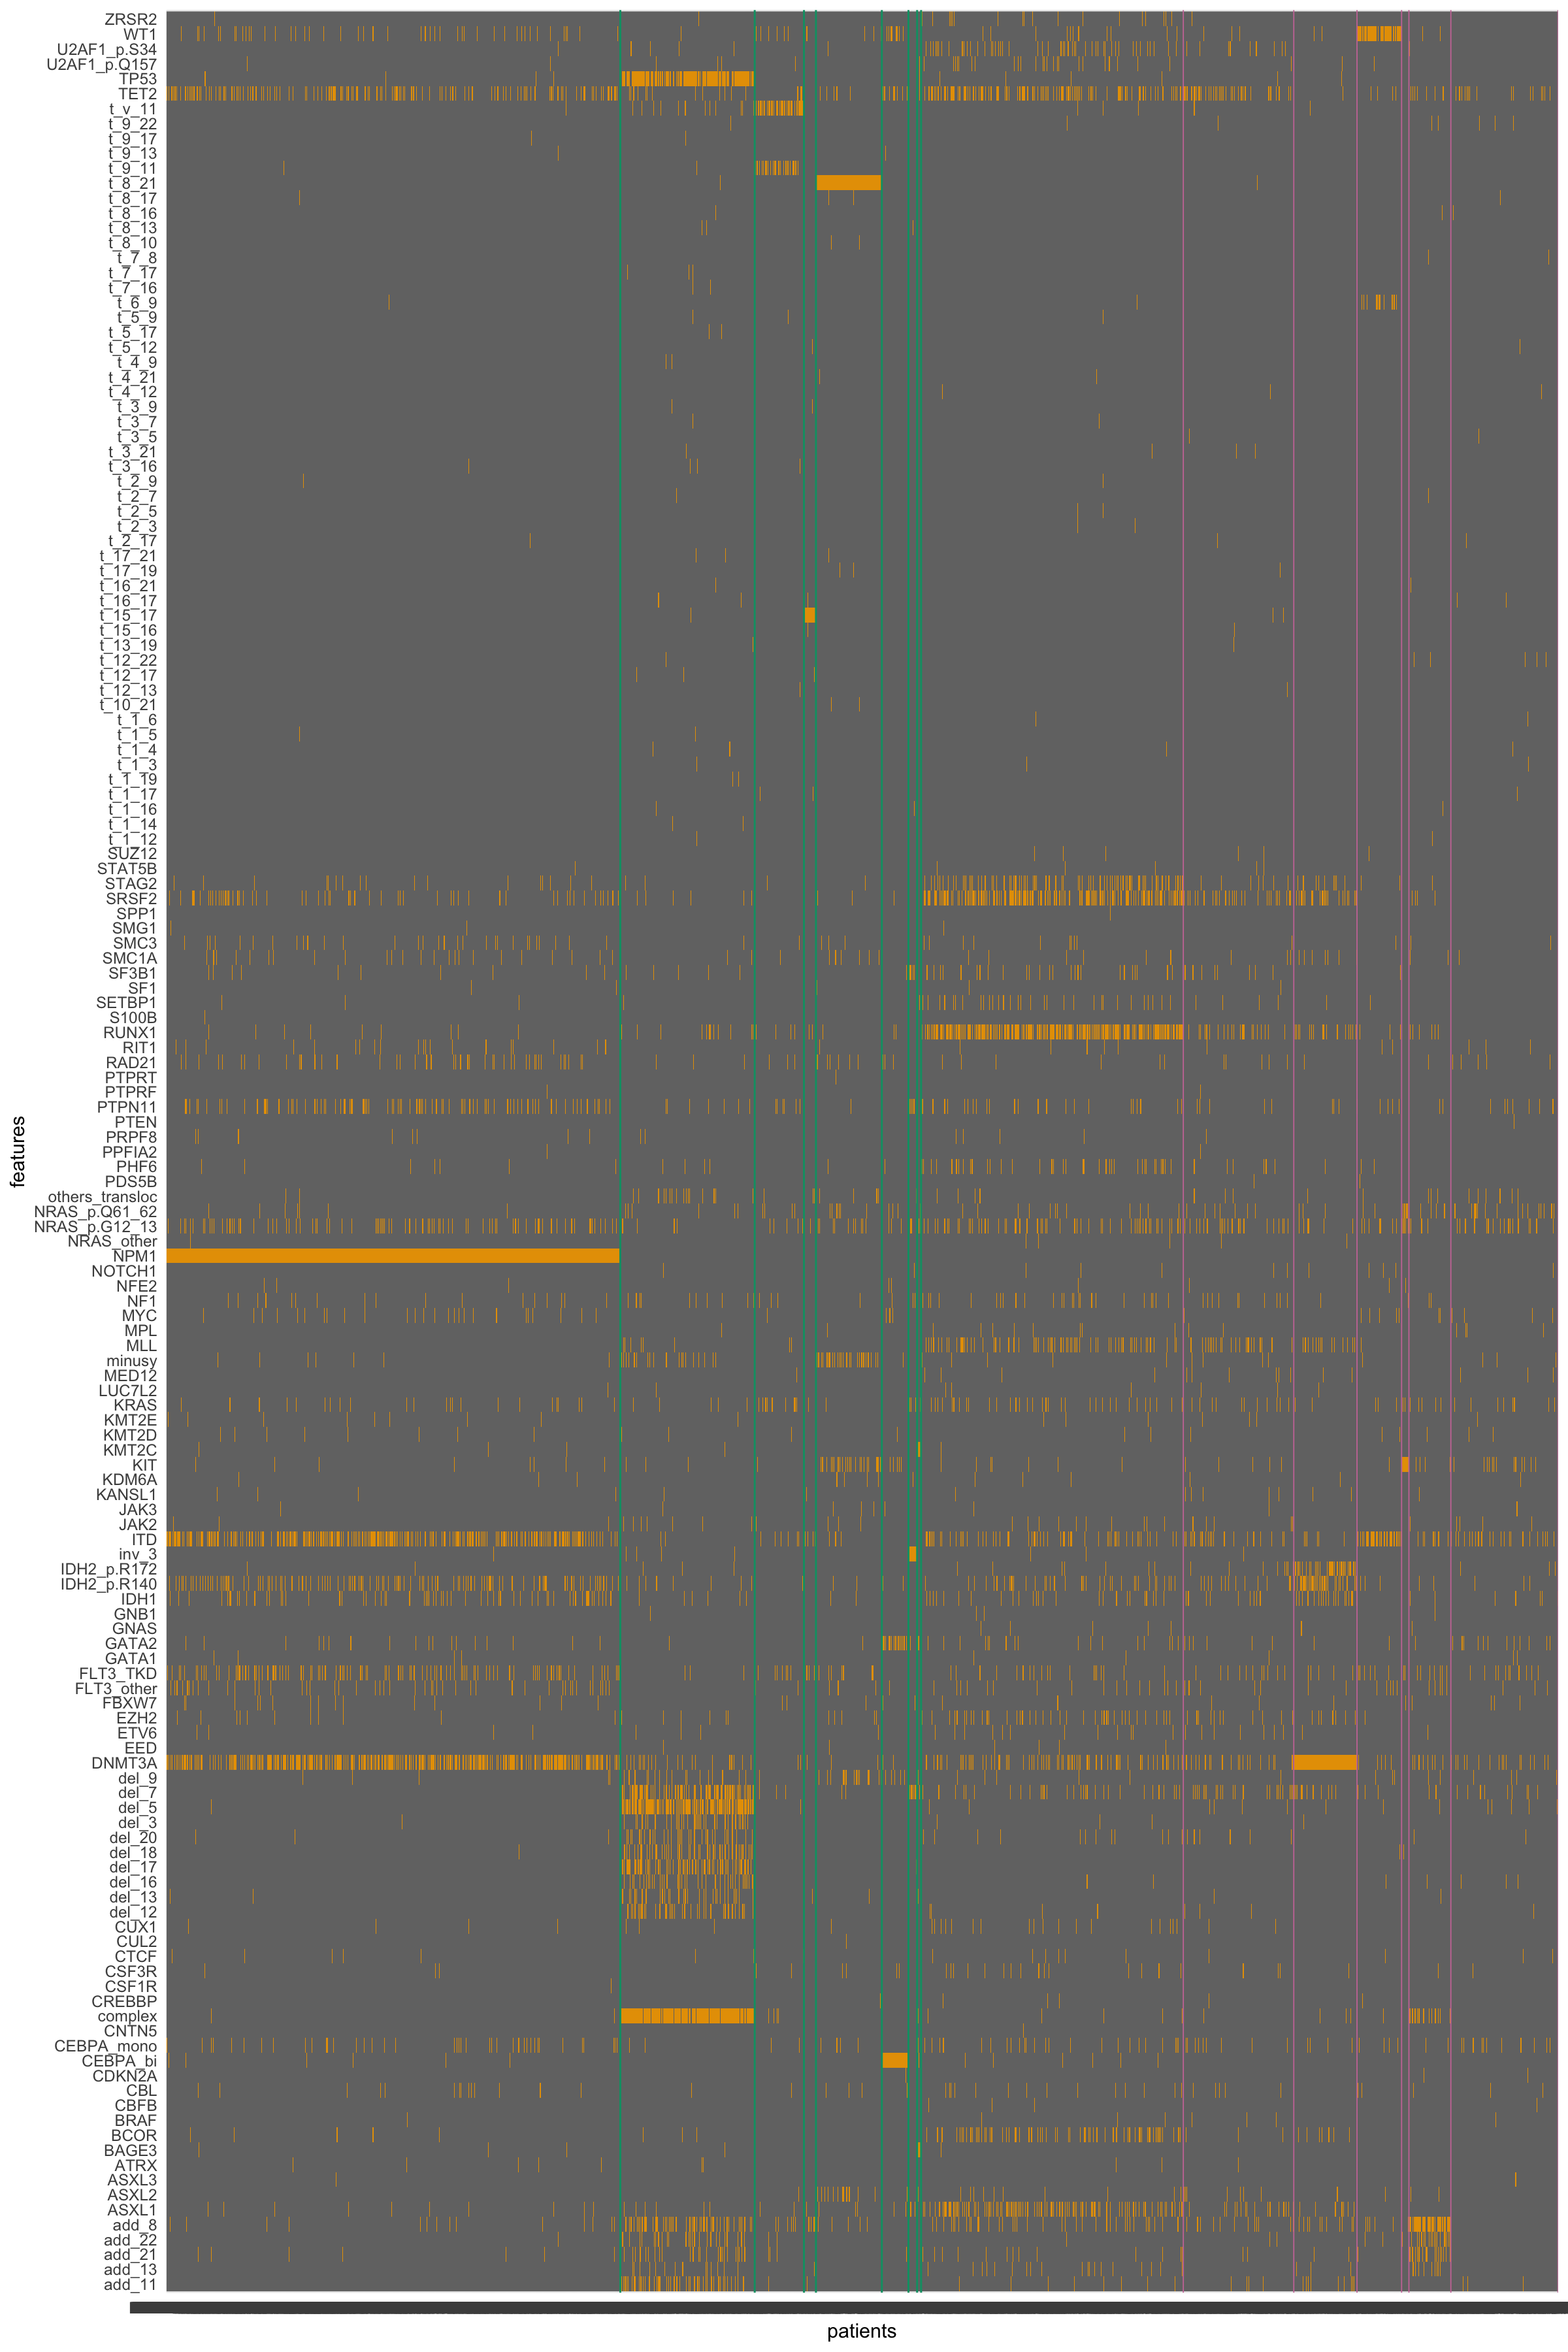

In [229]:
df_final_with_comp <- read.table("df_final_with_components.tsv")
cols_to_keep = c(1:153,155)
tmp_all <- df_final_with_comp[,cols_to_keep][order(df_final_with_comp[,cols_to_keep]$final_component_numeric),]
transp_df_all <-(as.data.frame(t(tmp_all)))
transp_df_all$features <- rownames(transp_df_all)
transp_df_all <- transp_df_all[! row.names(transp_df_all) == "final_component_numeric",]
melt.data_all<-melt(transp_df_all,id.vars ="features", variable_name=colnames(transp_df_all))
options(repr.plot.res = 200)
set_notebook_plot_size(12, 18)
col_sep <- tabulate(df_final_with_comp[,cols_to_keep]$final_component_numeric)   ## to separate by component

cat("Order of Components :","\n")
cat(paste(unique(df_final_with_comp[order(df_final_with_comp[,cols_to_keep]$final_component_numeric),]$final_component)," ,"))
# plot the heatmap
ggplot(melt.data_all, aes(variable,features)) +
geom_raster(aes(fill = factor(value)), show.legend = FALSE) +
scale_fill_manual(values = c("0" = "grey45", "1" = "#e79f00")) +
geom_vline(xintercept = cumsum(col_sep)[1:8] + 0.5, col = "#009E73", linetype = 1, size = 0.5) +
geom_vline(xintercept = cumsum(col_sep)[9:15] + 0.5, col = "#CC79A7", linetype = 1, size = 0.3) +
labs(x = 'patients') 

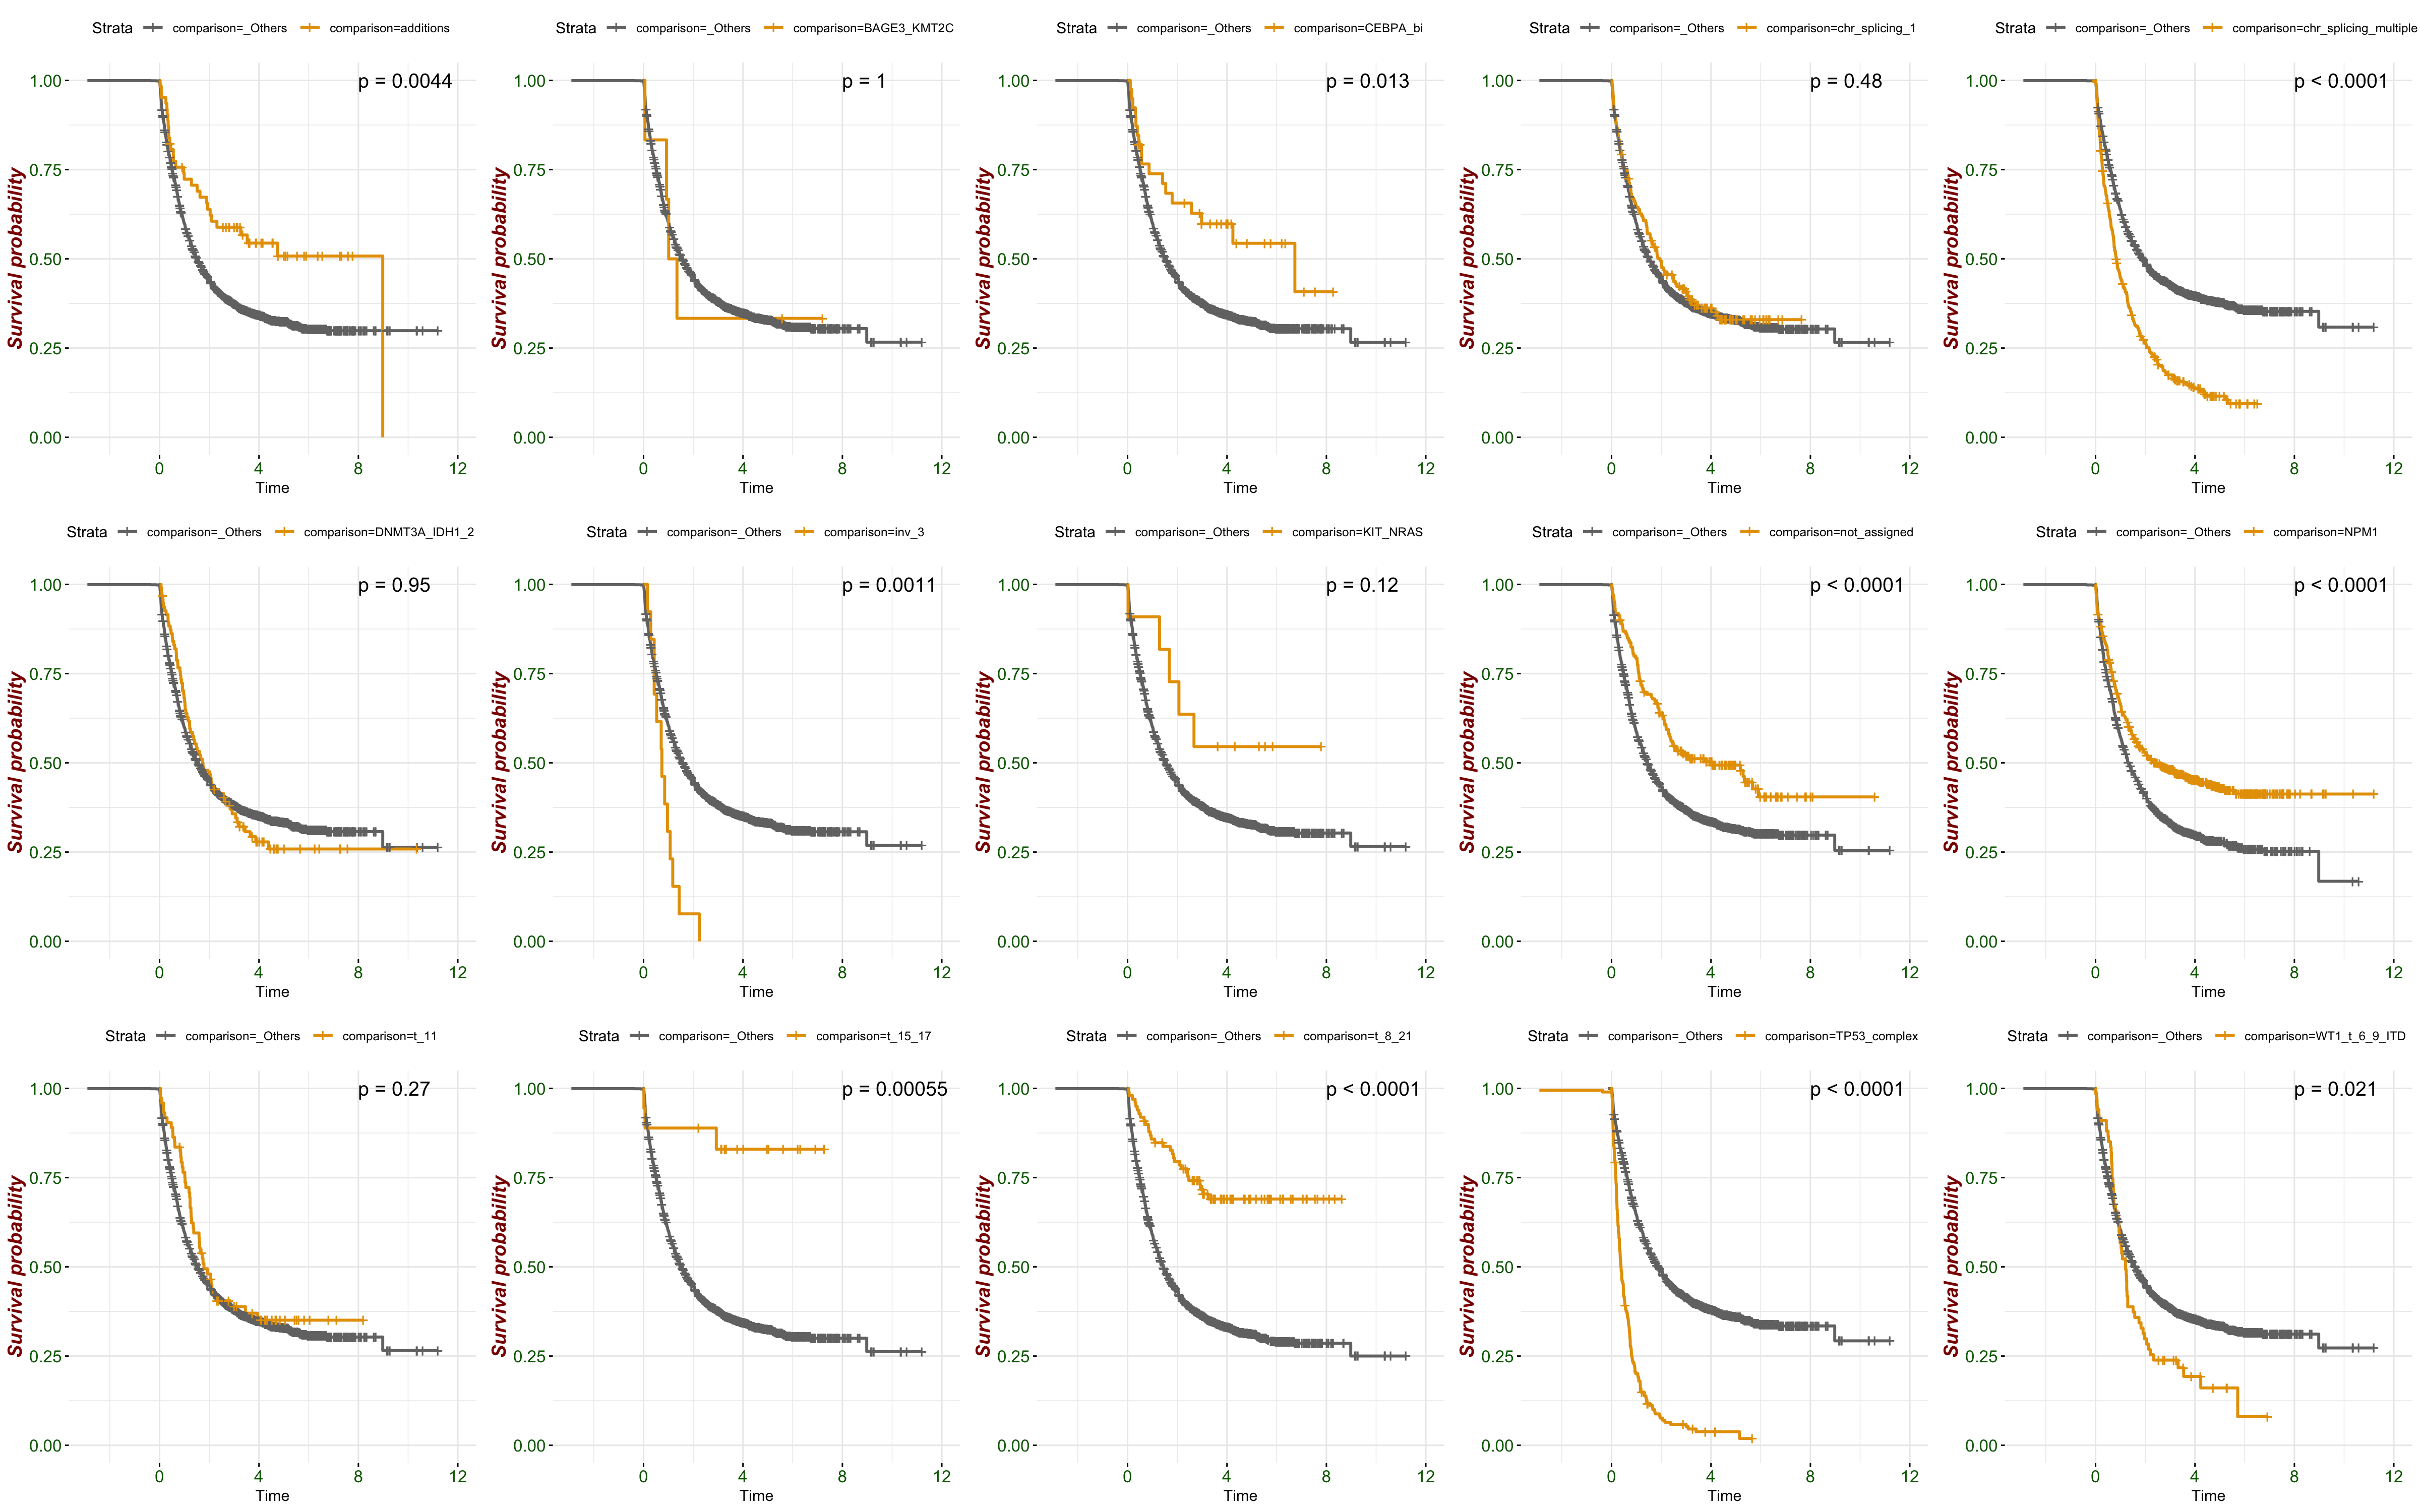

In [231]:
correlates <- c("gender","age","ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","os","cr","os_status")
binary_correlates <- c("gender","ahd","perf_status","secondary","os_status","cr")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts","os")
val=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
                                      "#9ad0f3", "#D55E00","lightskyblue","mistyrose4", 
                                      "darkseagreen","lightgoldenrod","lightsalmon","#F0E442",
                                      "firebrick3","#000000","#870C14","#a6bddb","#fdbb84","deeppink")
plot_surv <-function(df_surv,title="",width=15,heightDetailsht=6,vals=val){
    set_notebook_plot_size(width,height)
    surv_object <- Surv(time = df_surv$os, event = df_surv$os_status)
    fit1 <- survfit(surv_object ~ comparison, data = df_surv)
    ggsurvplot(fit1, data = df_surv, pval = TRUE,risk.table = TRUE,ggtheme = theme_minimal(),
    risk.table.y.text.col = T,
    risk.table.y.text = T,break.time.by = 1,title= title,palette=as.vector(vals[1:length(unique(df_surv$comparison))]))
}
df_initial <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T) 
rownames(df_initial) <- df_initial$data_pd
df_initial <- df_initial[,-1:-4]
df_w_correlates <- merge(df_initial[correlates],df_final_with_comp['final_component'],by=0)
rownames(df_w_correlates) <- df_w_correlates$Row.names
df_w_correlates <- df_w_correlates [,-1]
set_notebook_plot_size(24,15)
list_component <- levels(factor(df_w_correlates$final_component))
survlist <- list()
for (i in list_component){
tmp <- df_w_correlates
tmp$comparison <- ifelse((tmp$final_component==i),i,"_Others") 
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
survlist[[i]]<-ggsurvplot(fit, data = tmp, pval = TRUE,ggtheme = theme_minimal(),main = "Survival curve",
   font.main = c(16, "bold", "darkblue"),
   font.y = c(14, "bold.italic", "darkred"),  
   palette = c("grey45","#e79f00"),
   pval.coord=c(8,1),
   font.tickslab = c(12, "plain", "darkgreen"))$plot
}
grid.arrange(grobs=survlist,ncol=5)

In [11]:
h <- t(data.frame(table(read.table("df_final_with_components.tsv")$final_component)))
row.names(h) <- c("Final Component","Number of Patients")
h

[,1]      [,2]        [,3]     [,4]          
Final Component    additions BAGE3_KMT2C CEBPA_bi chr_splicing_1
Number of Patients  63         6          40      166           
                   [,5]                  [,6]          [,7]  [,8]    
Final Component    chr_splicing_multiple DNMT3A_IDH1_2 inv_3 KIT_NRAS
Number of Patients 394                    95            13    11     
                   [,9]         [,10] [,11] [,12]   [,13]  [,14]       
Final Component    not_assigned NPM1  t_11  t_15_17 t_8_21 TP53_complex
Number of Patients 161          682    74    18      99    202         
                   [,15]        
Final Component    WT1_t_6_9_ITD
Number of Patients  67

In [13]:
unique(read.table("df_final_with_components.tsv")$final_component)

[1] NPM1                  t_11                  TP53_complex         
 [4] CEBPA_bi              inv_3                 t_8_21               
 [7] t_15_17               BAGE3_KMT2C           chr_splicing_multiple
[10] chr_splicing_1        WT1_t_6_9_ITD         DNMT3A_IDH1_2        
[13] additions             not_assigned          KIT_NRAS             
15 Levels: additions BAGE3_KMT2C CEBPA_bi ... WT1_t_6_9_ITD